# Processing for frequency of oscillation

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 18})

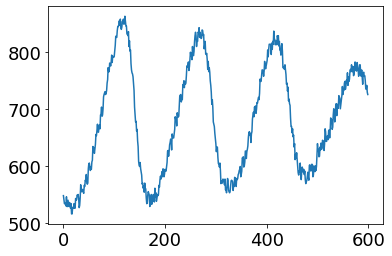

In [123]:
datapath = "./data/2candles_10bit_363_1.csv"
data = np.genfromtxt(datapath, delimiter=",")
plt.plot(data)
plt.show()

## Error estimation: Re-bin
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binned_statistic.html

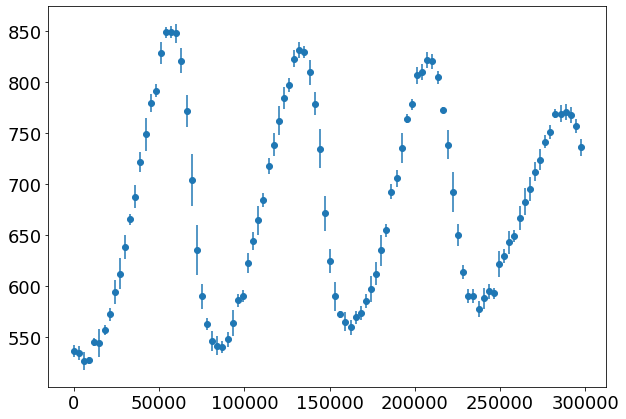

In [124]:
factor = 6 # number of consecutive points to average
n_bins = int(len(data)/factor)
assert len(data)/factor%1 == 0, "The rebinning factor must divide the length of data exactly"

timebase = 500
time = timebase*np.linspace(0, len(data), len(data))
time_rebinned = time[0::factor]

bin_means = binned_statistic(time, data, "mean", bins=n_bins)[0]
bin_std = binned_statistic(time, data, "std", bins=n_bins)[0]

plt.figure(figsize=(10,7))
plt.errorbar(time_rebinned, bin_means, bin_std, fmt="o")
plt.show()

In [125]:
def rebin(data, factor, verbose=False, timebase = 500):
    
    """
    data is the 1D array of intensities
    
    factor is how many consecutive points you want to average
    """
    
    #factor = 6 # number of consecutive points to average
    n_bins = int(len(data)/factor)
    #assert len(data)/factor%1 == 0, "The rebinning factor must divide the length of data exactly"

    time = timebase*np.linspace(0, len(data), len(data))
    time_rebinned = time[0::factor]
    
    
    bin_means = binned_statistic(time, data, "mean", bins=n_bins)[0]
    bin_std = binned_statistic(time, data, "std", bins=n_bins)[0]
    if len(time_rebinned) > len(bin_means):
        time_rebinned = time_rebinned[:-1]
    #if verbose:
        #plt.figure(figsize=(10,7))
        #plt.errorbar(time_rebinned, bin_means, bin_std, fmt="o")
        #plt.show()
        
    return time_rebinned, bin_means, bin_std

## Extracting the frequency/period with a curve fit

/tmp/ipykernel_80531/2975652453.py:7: RuntimeWarning: overflow encountered in exp
  return a * np.exp(lam * t) * np.cos(w * t) + A0
/home/yuliya/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


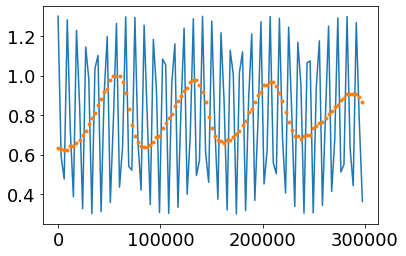

In [126]:
r = rebin(data, 6) # the data we're working with

def cos(t, A, w, d, A0):
    return A*np.cos(t*w + d) + A0

def decaying_sinusoid(t, a, lam, w, A0):
    return a * np.exp(lam * t) * np.cos(w * t) + A0

popt, pcov = curve_fit(decaying_sinusoid, r[0], r[1]/max(r[1]), sigma=r[2], p0=[0.5, 1200, 6e-5, 0.8])

plt.plot(r[0], cos(r[0], *popt))
plt.plot(r[0], r[1]/max(r[1]), ".")

## Trying another method: using find_peaks
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

Sources of error on the periods:
- peak location (from find_peaks) -- due to binning and due to threshold (are they different?) -- just use the distance to the nearest neighbor
- averaging between cycles of one run (statistical error)

60 60


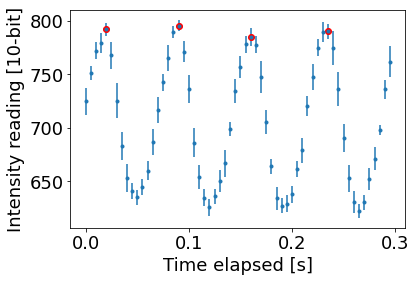

Period: 0.0717863105175292 +- 0.005536936210943909 s

0.005008347245409014 0.0023609575331771304


(0.0717863105175292, 0.005536936210943909, 9.871316782425671)

In [127]:
def find_oscillations(data, rebin_factor=6, verbose=False):
    """returns period of oscillation for the data run
    
    data: 1D array
    rebin_factor: int (number of data points to average together)
    verbose: set to True if you want to print EVERYTHING
    """

    r = rebin(data, rebin_factor, verbose) # the data we're working with

    peaks_loc = find_peaks(r[1], height=np.mean(r[1]), distance=10)[0] # select only the top peaks
    
    if verbose:
        print(len(r[0]), len(r[1]))
        plt.errorbar(r[0]/1e6, r[1], r[2], fmt=".")
        
        plt.plot(r[0][peaks_loc]/1e6, r[1][peaks_loc], "ro")
        plt.xlabel("Time elapsed [s]")
        plt.ylabel("Intensity reading [10-bit]")
        plt.show()

    # find the period (in seconds)
    periods = np.diff(r[0][peaks_loc])/1e6
    p = np.mean(periods)
    dt = np.diff(r[0])[0]/1e6 # time difference between neighboring points
    dp = np.sqrt(dt**2 + np.std(periods)**2)
    
    # determine the error on intensity readings
    err = np.nanmean(r[2])
    
    if verbose:
        
        print("Period:", p, "+-", dp, "s") # systematic and stat errors combined
        print()
        print(dt, np.std(periods)) # compare the magnitudes of systematic and stat errors
    
    return (p, dp, err)

datapath = "./data/2candles_10bit_363_14.csv"
data = np.genfromtxt(datapath, delimiter=",")
find_oscillations(data,verbose=True, rebin_factor=10)

# 2 candles

for factor 3: 0.05402193591050019 +- 0.01861128873196496 s
[6.56383034 7.66057826 6.50474483 7.79107879 6.29171099 5.65344328
 6.36116385 6.47575519 6.53547194 5.96942478 6.5239461  5.2474777
 5.0097669  5.01799163 5.28347106 5.89221313 6.44777177 4.78797802
 5.0104524  5.25185476 6.0549405  5.65914027]
for factor 4: 0.06987403247837304 +- 0.005779366551672365 s
[7.52480921 8.55441961 7.33514711 8.45001691 7.90482628 7.46380302
 8.01310178 7.24596194 7.95141609 6.93951662 8.38012222 6.07966643
 6.26458015 6.44647147 6.44741138 7.12127875 8.66670305 5.78009162
 6.12409894 6.86563382 7.89224095 6.92028259]
for factor 5: 0.07074290484140232 +- 0.005431229194148928 s
[ 8.58600172 10.46574102  8.30406387  9.9833142   9.02322487  7.96933878
  8.67455156  8.22989878  9.21369113  8.47829147  9.4248158   6.92198906
  7.07786544  6.92286195  7.71415952  8.21645417 10.27322646  7.28173583
  6.92007917  8.07004774  9.60501996  7.6705132 ]
for factor 6: 0.07069737441189862 +- 0.005734827224312267 s

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


for factor 20: nan +- nan s
[20.96193768 28.8632871  17.56697571 26.81841636 23.00195107 18.74322374
 22.3294827  18.18169667 26.78709402 22.8193809  28.87989262 13.58276872
 15.82929728 15.91722445 19.64227569 20.06382988 35.83078754 23.51390374
 13.84622524 23.80886872 31.68197973 19.64459773]
for factor 21: nan +- nan s
[21.610578   34.11112198 20.33572558 32.56194673 24.46656573 20.1752465
 24.0130585  18.62381857 28.65796405 24.15832979 30.09233606 15.0884679
 16.80035178 16.11445816 21.49860185 21.54744529 37.26712276 25.18989583
 14.8766433  25.41611955 34.77184279 21.54072928]
for factor 22: nan +- nan s
[23.68100567 34.93965327 20.67126783 34.47419616 24.89690509 20.55002242
 24.33112288 19.31796936 29.84755461 24.99787249 31.50510244 14.75586576
 17.14622341 17.12423199 22.01846719 22.62403093 39.57093062 27.1764208
 14.8913369  25.99527414 35.22852689 21.87179646]
for factor 23: nan +- nan s
[23.7684622  36.61215448 21.55788123 34.36892631 26.06701461 21.4387904
 25.55418963

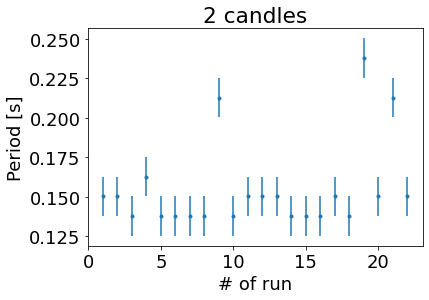

In [134]:
datapaths = ["./data/2candles_10bit_363_{}.csv".format(int(x)) for x in np.linspace(1, 22, 22)]
factors = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
p_2candles = np.zeros((len(factors), 2))
errors = np.zeros((len(factors), 2))

for i, f in enumerate(factors):
    p = []
    dp = []
    intensity_err = []
    for d in datapaths:
        #print(d)
        
        data = np.genfromtxt(d, delimiter=",")
        period, error, err_on_intensity = find_oscillations(data, rebin_factor=f, verbose=False)
        p.append(period)
        dp.append(error)
        intensity_err.append(err_on_intensity)
    p = np.asarray(p)
    dp = np.asarray(dp)
    intensity_err = np.asarray(intensity_err)
    
    errors[i, :] = np.array([np.nanmean(intensity_err), np.nanstd(intensity_err)])
    print("for factor " + str(f) + ":", np.mean(p), "+-", np.mean(dp), "s" )
    print(intensity_err)
    p_2candles[i, :] = np.array([np.nanmean(p), np.nanmean(dp)])

print(p_2candles)
plt.title("2 candles")
plt.errorbar(np.linspace(1,22,22), p, dp, fmt=".")
plt.xlabel("# of run")
plt.ylabel("Period [s]")
plt.show()

print()

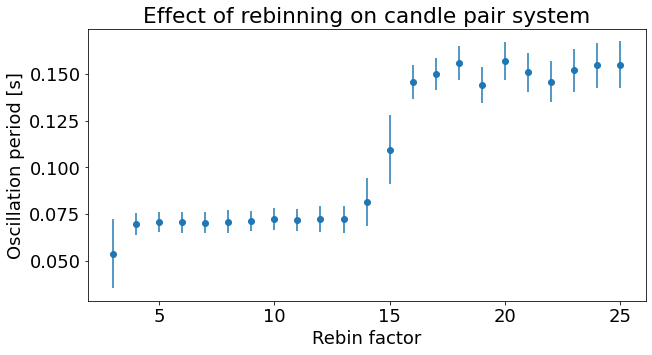

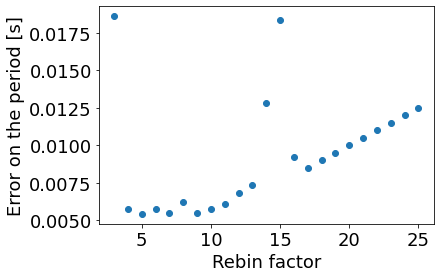

In [92]:
plt.figure(figsize = (10,5))
plt.title("Effect of rebinning on candle pair system")
plt.errorbar(factors, p_2candles[:, 0], yerr=p_2candles[:, 1], fmt="o")
plt.ylabel("Oscillation period [s]")
plt.xlabel("Rebin factor")
plt.show()

plt.plot(factors, p_2candles[:, 1], f"o")
plt.ylabel("Error on the period [s]")
plt.xlabel("Rebin factor")
plt.show()

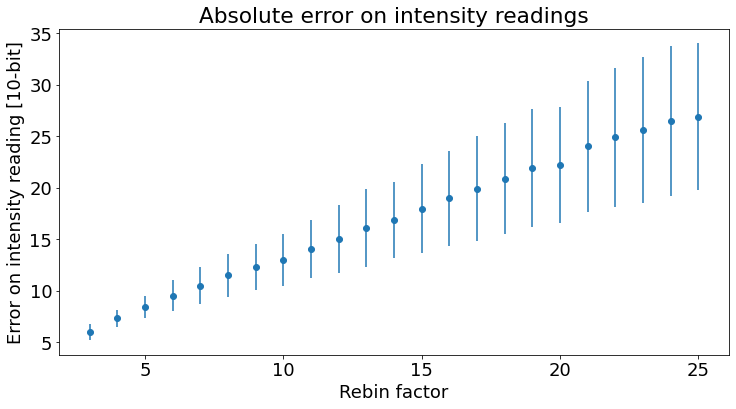

In [141]:
plt.figure(figsize = (12,6))
plt.title("Absolute error on intensity readings")
plt.ylabel("Error on intensity reading [10-bit]")
plt.xlabel("Rebin factor")
plt.errorbar(factors, errors[:,0], yerr=errors[:,1], fmt="o")
plt.show()

In [153]:
# calculating the period
p_2 = (p_2candles[6, 0], p_2candles[6, 1])
print(p_2)

(0.07140309606920625, 0.005496979898922383)


# 3 candles

for factor 3: 0.04108237023095119 +- 0.019780330404695175 s
for factor 4: 0.057948317981706965 +- 0.015543039561131003 s
for factor 5: 0.07030975048504264 +- 0.007378233005390095 s
for factor 6: 0.07599828543067273 +- 0.004539934947386998 s
for factor 7: 0.07583359653476515 +- 0.004784908467406354 s
for factor 8: 0.07618102242476199 +- 0.004966604526740168 s
for factor 9: 0.07553129089022244 +- 0.005574430831313003 s
for factor 10: 0.07629833506294274 +- 0.005900266528648559 s
for factor 11: 0.07561476334431258 +- 0.006123866822913918 s
for factor 12: 0.07639759960294185 +- 0.006554691012654443 s
for factor 13: 0.07642918377475971 +- 0.007345994006249521 s
for factor 14: 0.07990795469927355 +- 0.009440822300921468 s
for factor 15: 0.09427875287641566 +- 0.013376466577724589 s


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


for factor 16: nan +- nan s
35 35


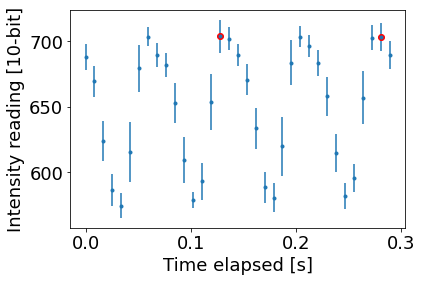

Period: 0.15325542570951592 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


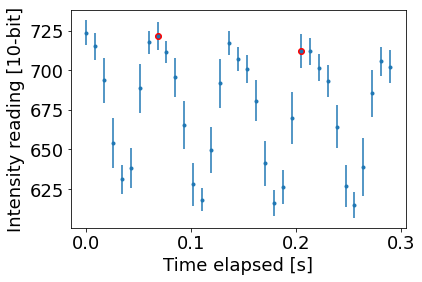

Period: 0.13622704507512517 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


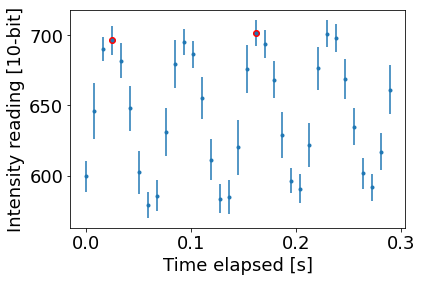

Period: 0.1362270450751252 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


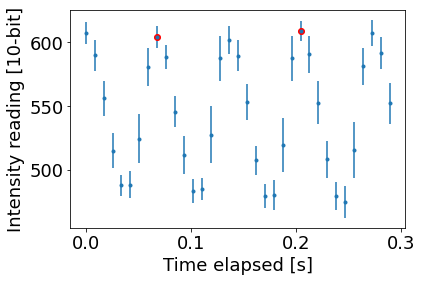

Period: 0.13622704507512517 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


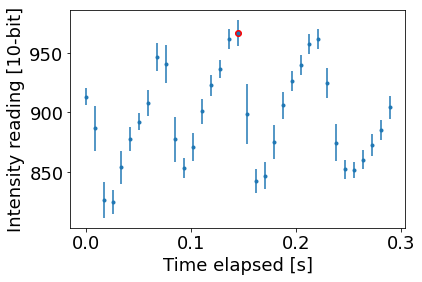

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.008514190317195325 nan
35 35


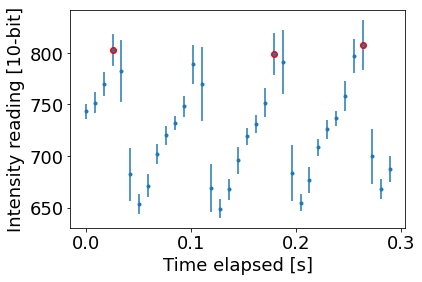

Period: 0.11919866444073456 +- 0.035104905994407465 s

0.008514190317195325 0.03405676126878131
35 35


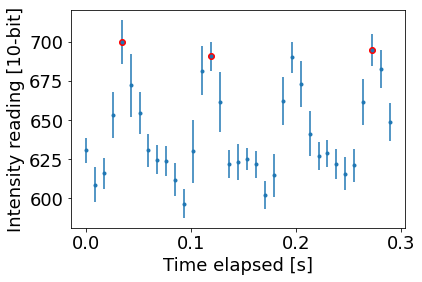

Period: 0.11919866444073456 +- 0.035104905994407465 s

0.008514190317195325 0.03405676126878131
35 35


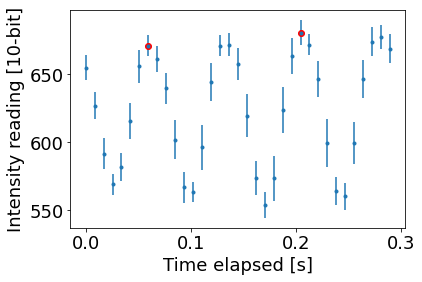

Period: 0.14474123539232053 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


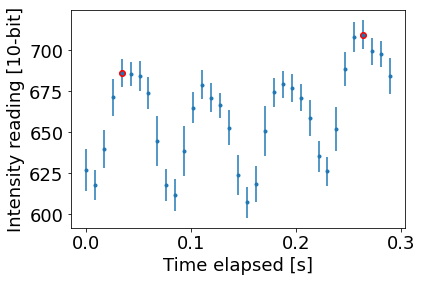

Period: 0.2298831385642738 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


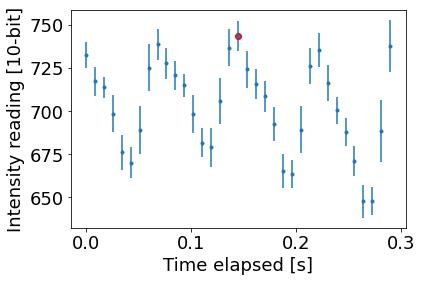

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.008514190317195325 nan
35 35


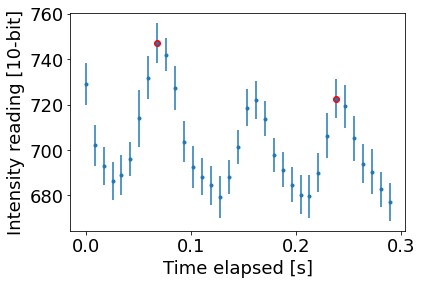

Period: 0.1702838063439065 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


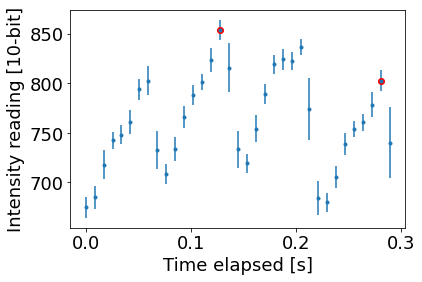

Period: 0.15325542570951592 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


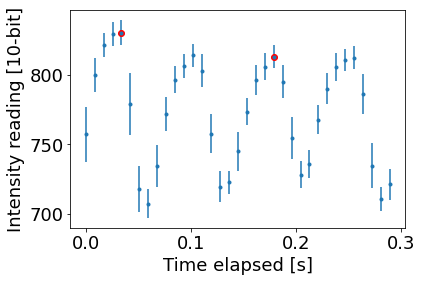

Period: 0.14474123539232056 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


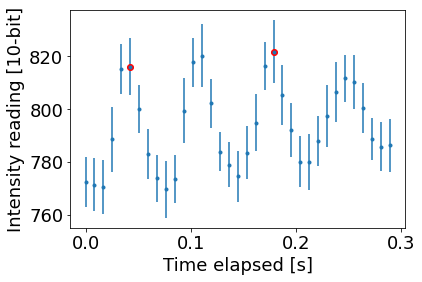

Period: 0.1362270450751252 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


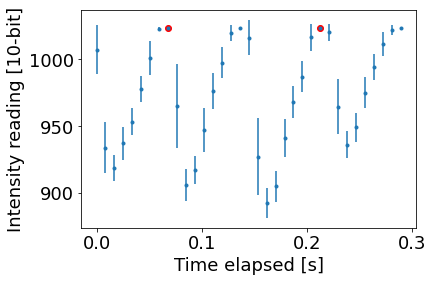

Period: 0.14474123539232056 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


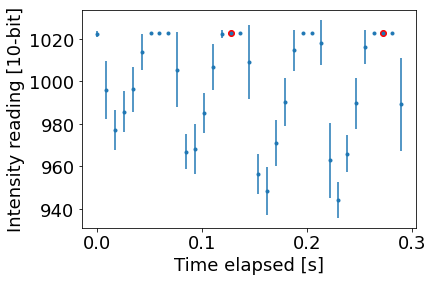

Period: 0.14474123539232056 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


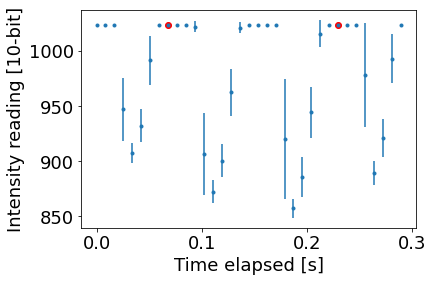

Period: 0.1617696160267112 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


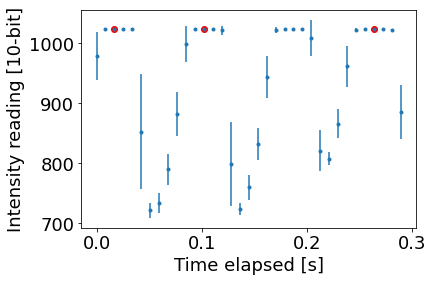

Period: 0.12345575959933222 +- 0.03924847807361748 s

0.008514190317195325 0.03831385642737897
35 35


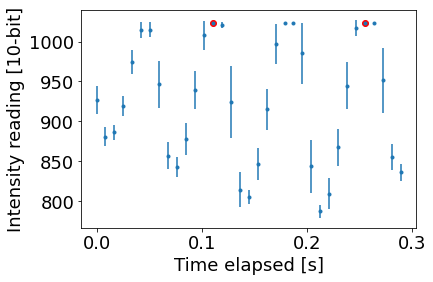

Period: 0.14474123539232053 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


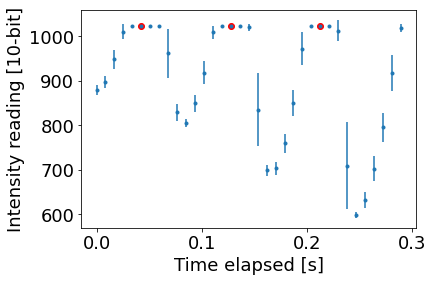

Period: 0.08514190317195325 +- 0.008514190317195325 s

0.008514190317195325 9.813077866773595e-18
35 35


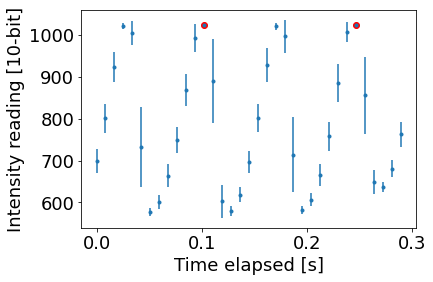

Period: 0.14474123539232056 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


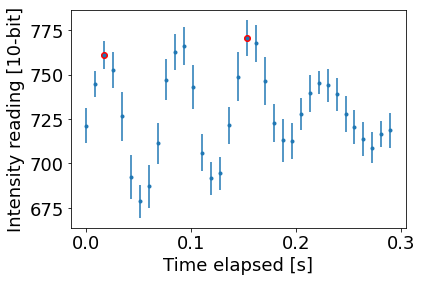

Period: 0.1362270450751252 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


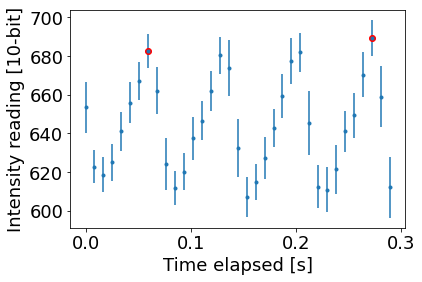

Period: 0.21285475792988315 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


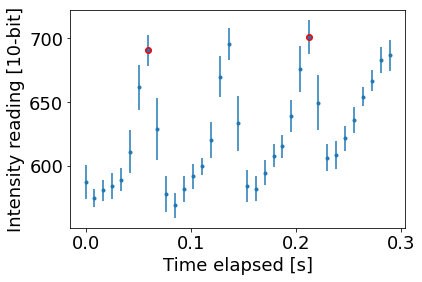

Period: 0.15325542570951586 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


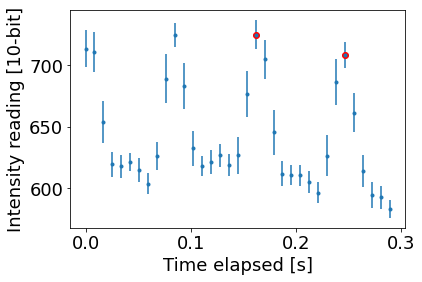

Period: 0.08514190317195328 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


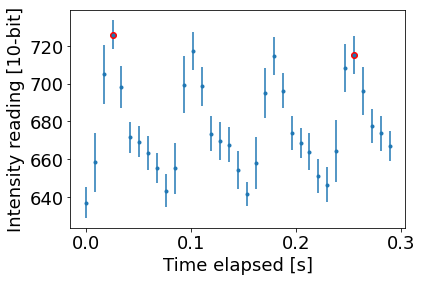

Period: 0.22988313856427378 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


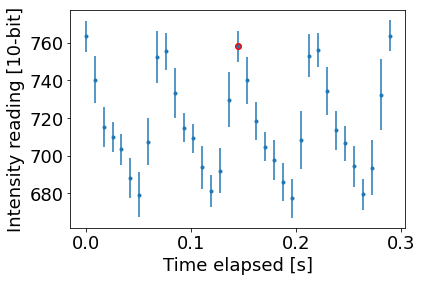

Period: nan +- nan s

0.008514190317195325 nan
35 35


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


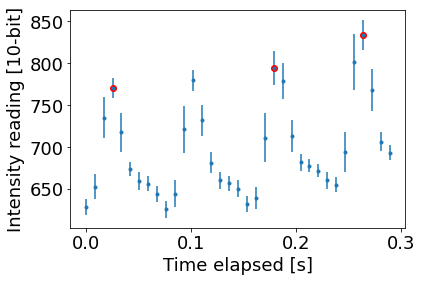

Period: 0.11919866444073456 +- 0.035104905994407465 s

0.008514190317195325 0.03405676126878131
35 35


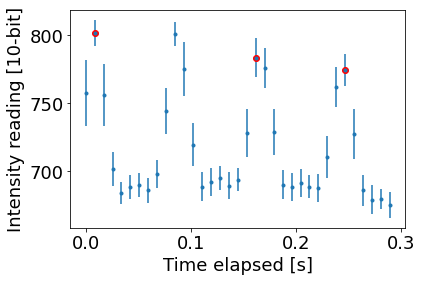

Period: 0.11919866444073457 +- 0.03510490599440745 s

0.008514190317195325 0.034056761268781294
35 35


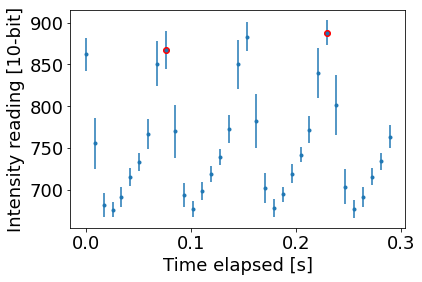

Period: 0.15325542570951586 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


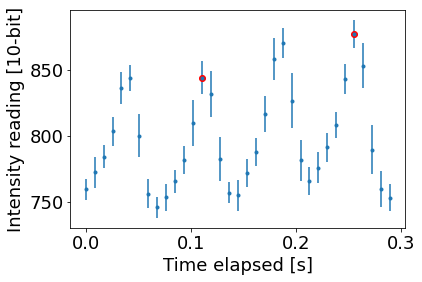

Period: 0.14474123539232053 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


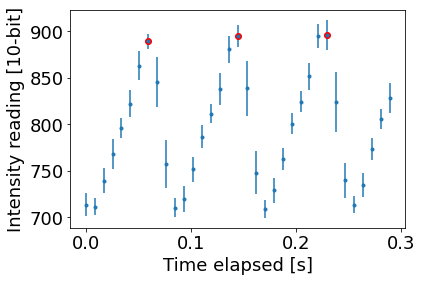

Period: 0.08514190317195326 +- 0.008514190317195325 s

0.008514190317195325 1.3877787807814457e-17
35 35


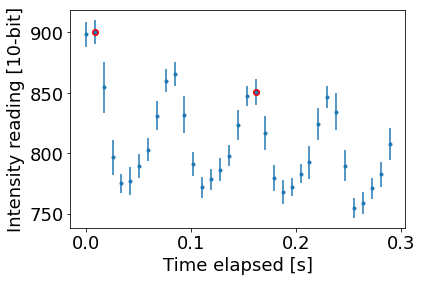

Period: 0.15325542570951586 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


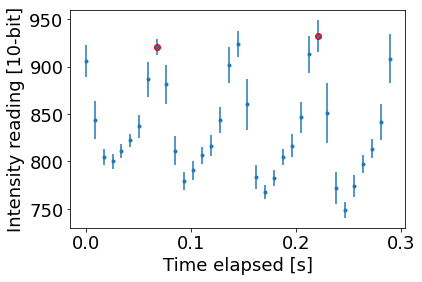

Period: 0.15325542570951586 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


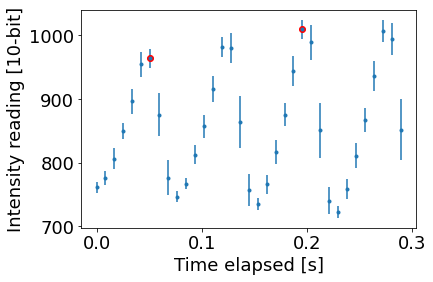

Period: 0.14474123539232053 +- 0.008514190317195325 s

0.008514190317195325 0.0
35 35


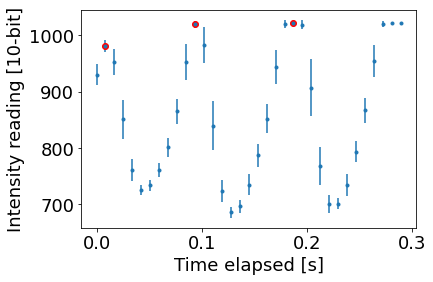

Period: 0.08939899833055091 +- 0.009519154161309624 s

0.008514190317195325 0.004257095158597665
35 35


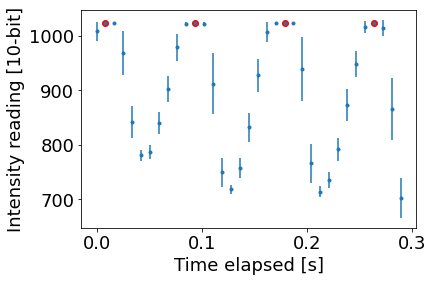

Period: 0.08514190317195325 +- 0.008514190317195325 s

0.008514190317195325 8.012344526598183e-18
for factor 17: nan +- nan s
33 33


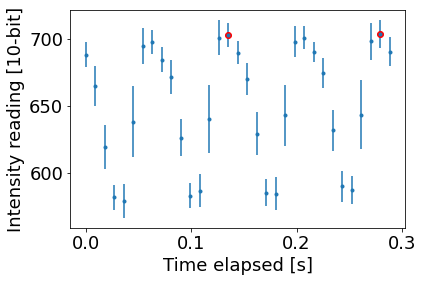

Period: 0.1442404006677796 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


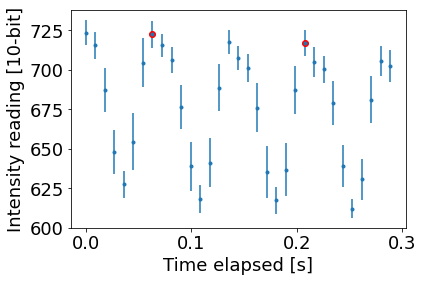

Period: 0.14424040066777966 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


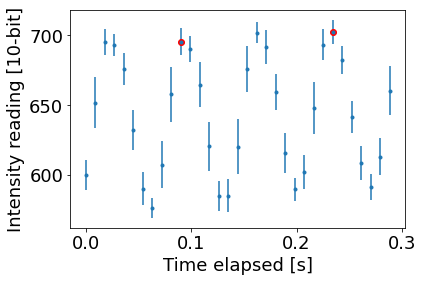

Period: 0.1442404006677796 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


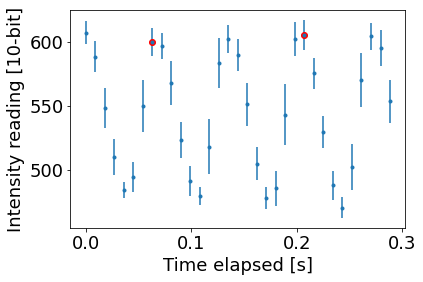

Period: 0.14424040066777966 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


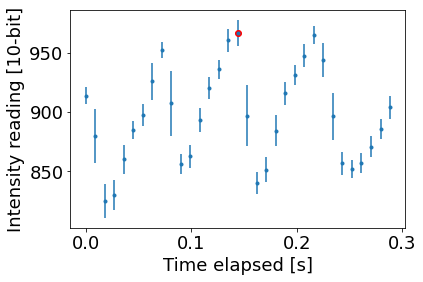

Period: nan +- nan s

0.009015025041736225 nan
33 33


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


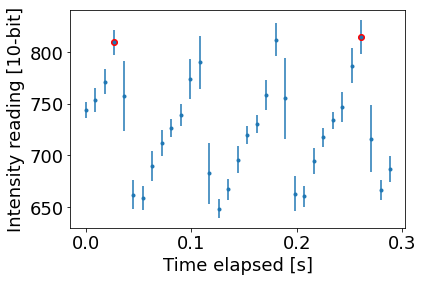

Period: 0.23439065108514193 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


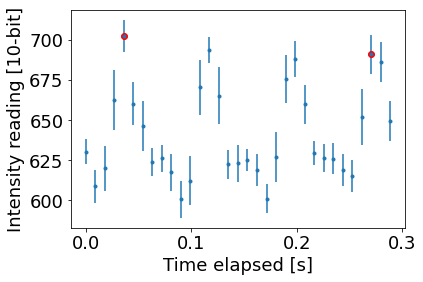

Period: 0.23439065108514193 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


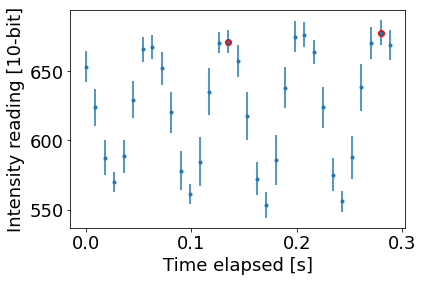

Period: 0.1442404006677796 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


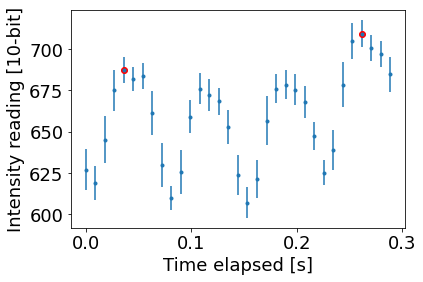

Period: 0.2253756260434057 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


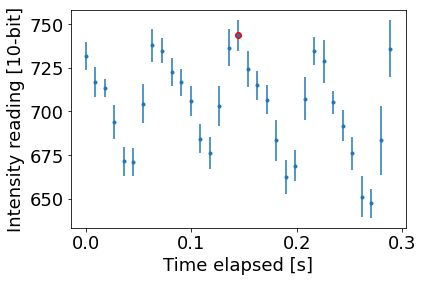

Period: nan +- nan s

0.009015025041736225 nan
33 33


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


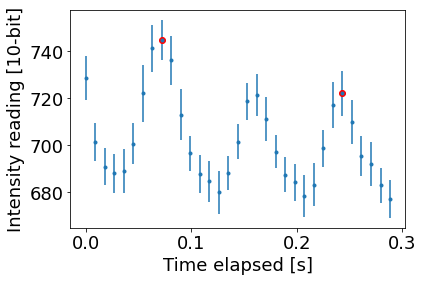

Period: 0.1712854757929883 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


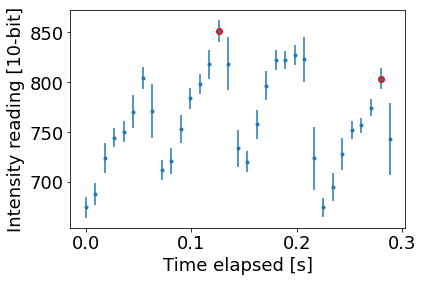

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


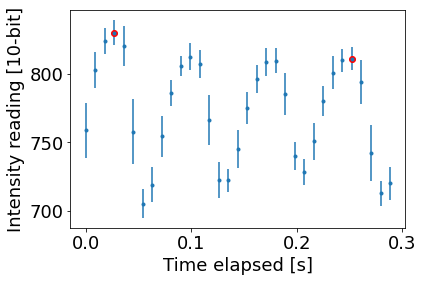

Period: 0.22537562604340566 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


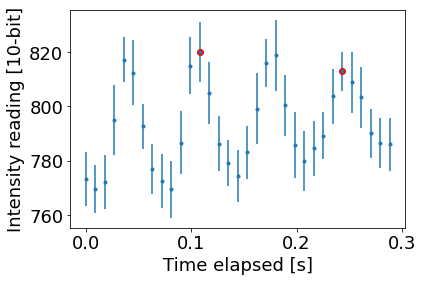

Period: 0.13522537562604342 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


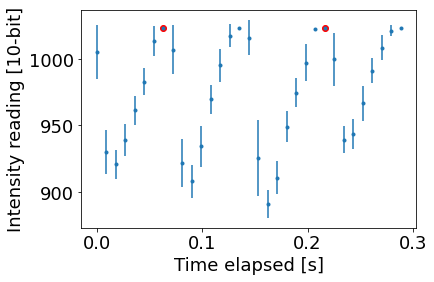

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


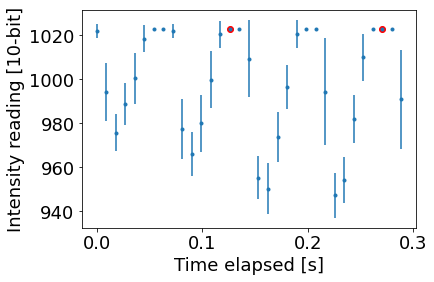

Period: 0.14424040066777968 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


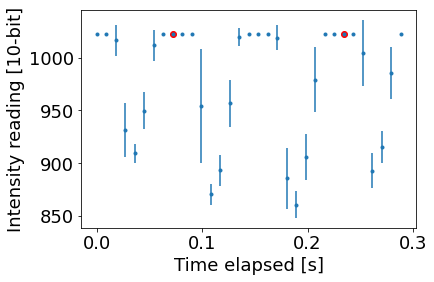

Period: 0.1622704507512521 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


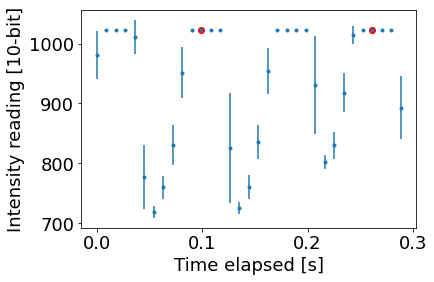

Period: 0.16227045075125213 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


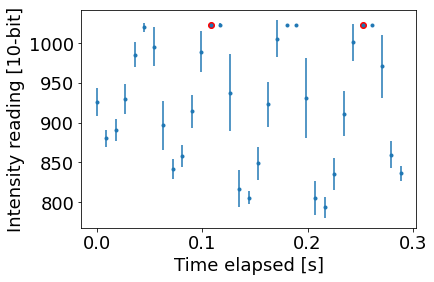

Period: 0.1442404006677796 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


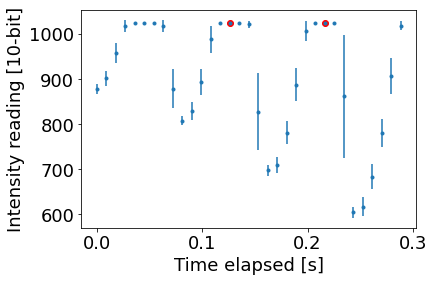

Period: 0.09015025041736227 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


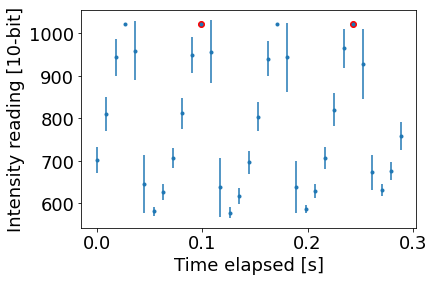

Period: 0.1442404006677796 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


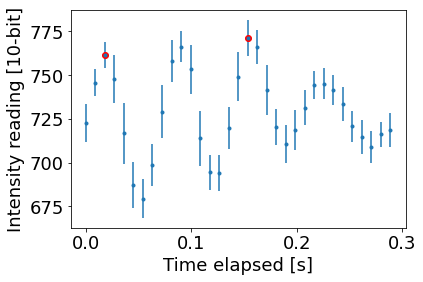

Period: 0.13522537562604342 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


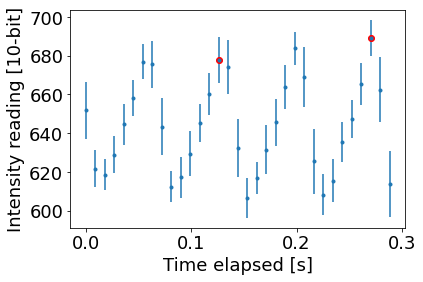

Period: 0.14424040066777968 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


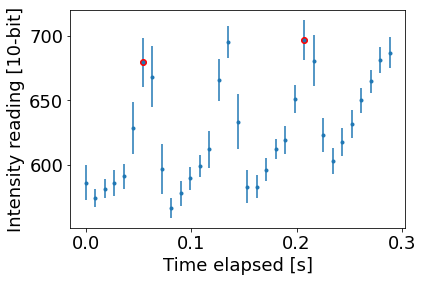

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


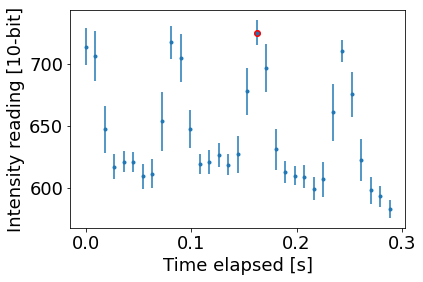

Period: nan +- nan s

0.009015025041736225 nan
33 33


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


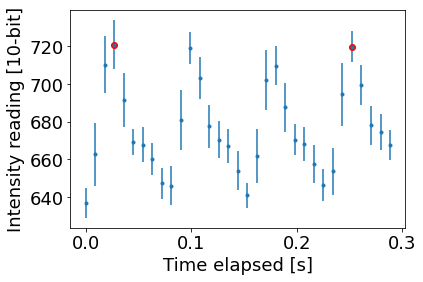

Period: 0.22537562604340566 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


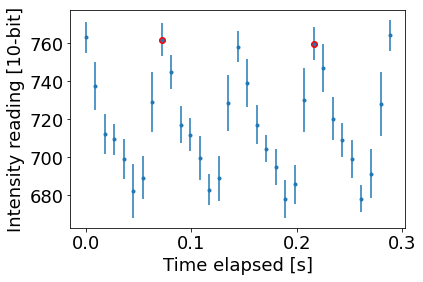

Period: 0.14424040066777966 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


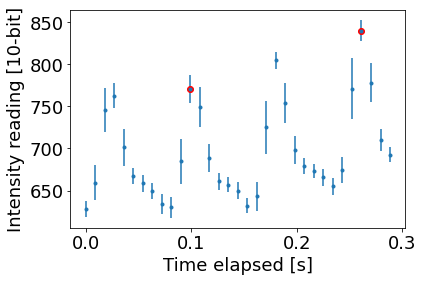

Period: 0.16227045075125213 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


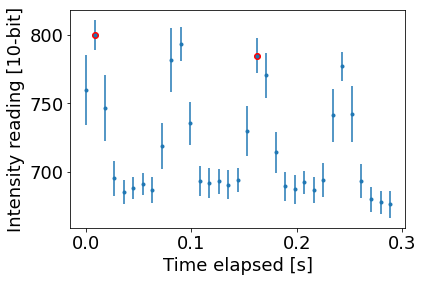

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


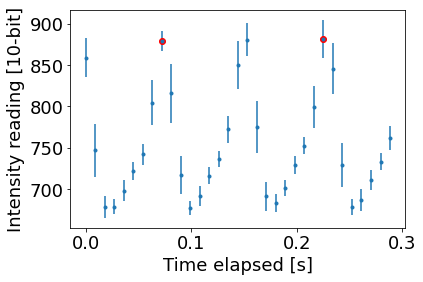

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


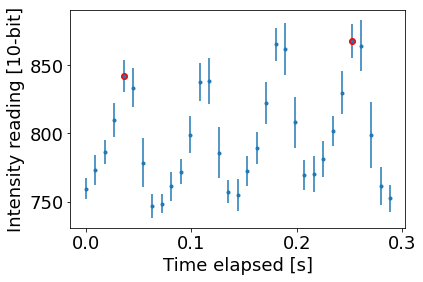

Period: 0.21636060100166946 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


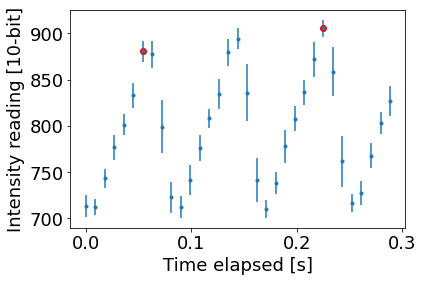

Period: 0.1712854757929883 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


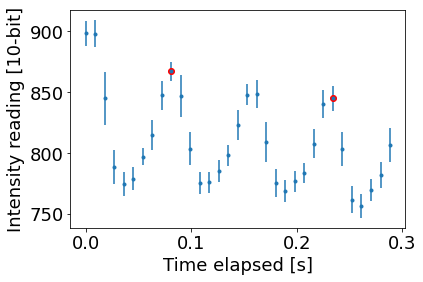

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


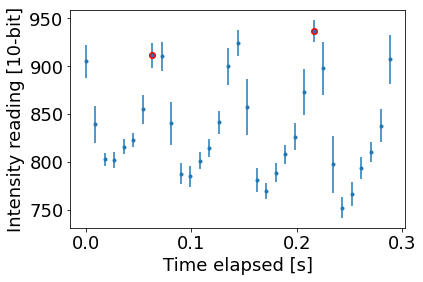

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


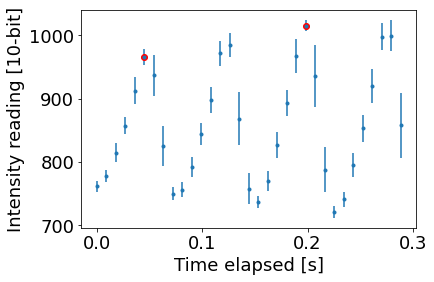

Period: 0.15325542570951586 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


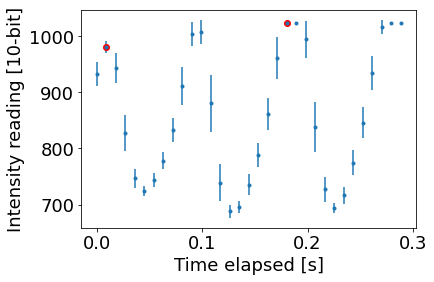

Period: 0.1712854757929883 +- 0.009015025041736225 s

0.009015025041736225 0.0
33 33


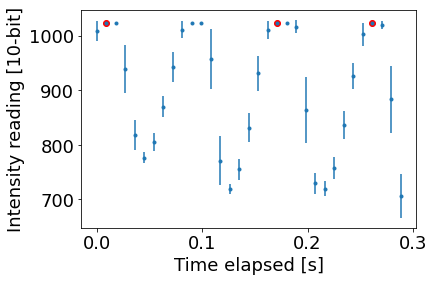

Period: 0.12621035058430718 +- 0.03716990046466672 s

0.009015025041736225 0.03606010016694491
for factor 18: nan +- nan s
31 31


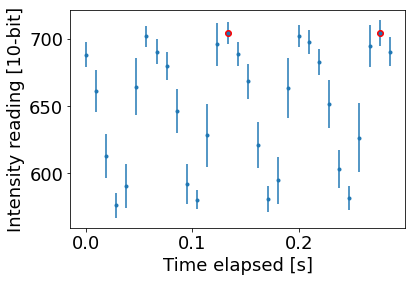

Period: 0.14273789649415694 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


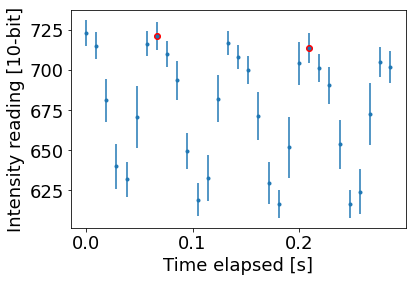

Period: 0.1427378964941569 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


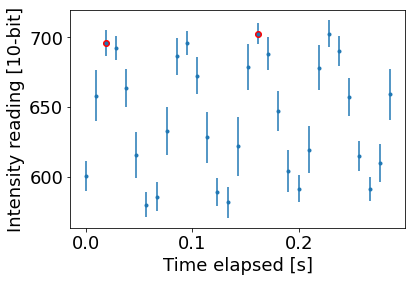

Period: 0.1427378964941569 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


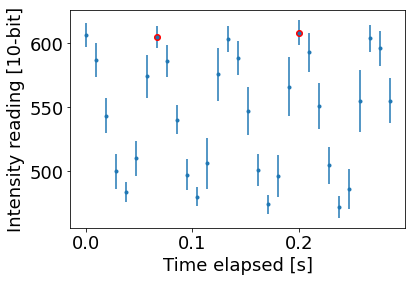

Period: 0.13322203672787977 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


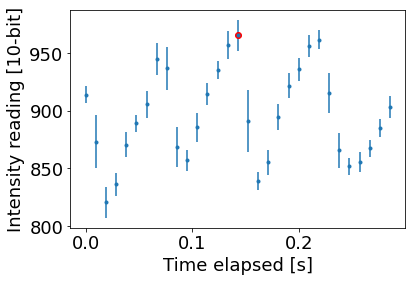

Period: nan +- nan s

0.009515859766277128 nan
31 31


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


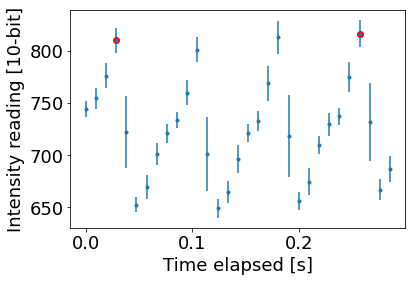

Period: 0.22838063439065107 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


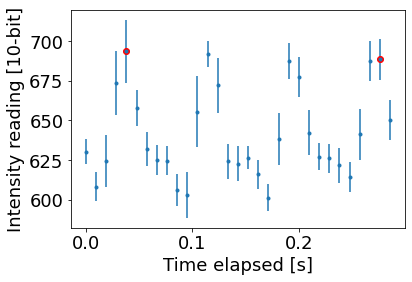

Period: 0.23789649415692823 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


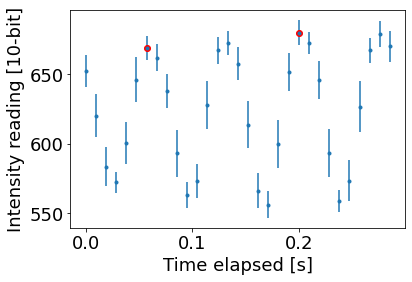

Period: 0.1427378964941569 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


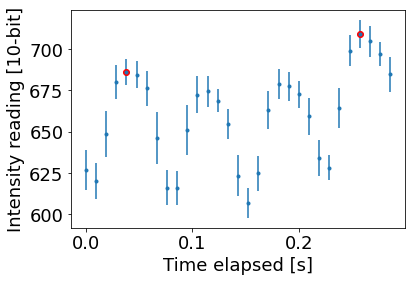

Period: 0.21886477462437393 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


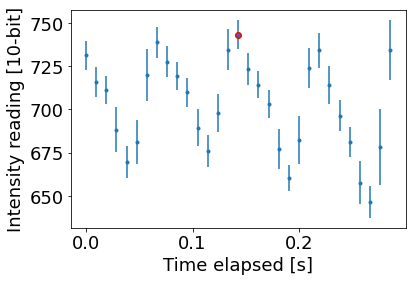

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.009515859766277128 nan
31 31


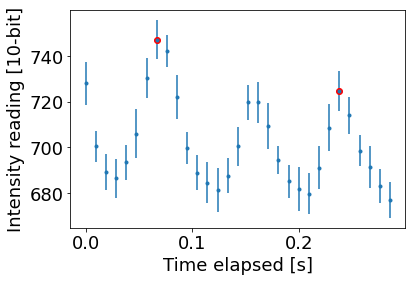

Period: 0.1712854757929883 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


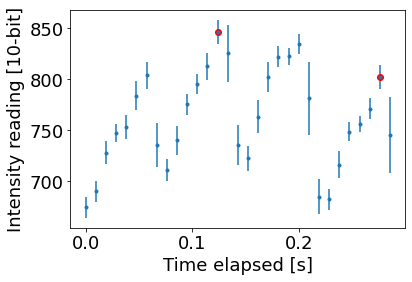

Period: 0.15225375626043408 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


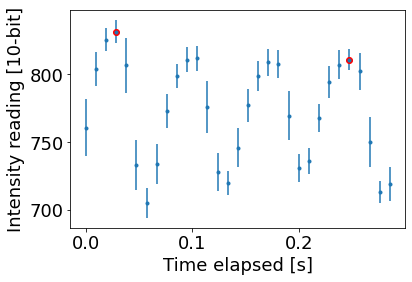

Period: 0.21886477462437398 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


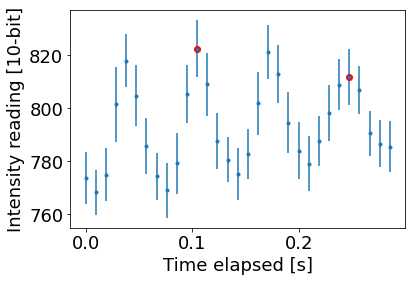

Period: 0.1427378964941569 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


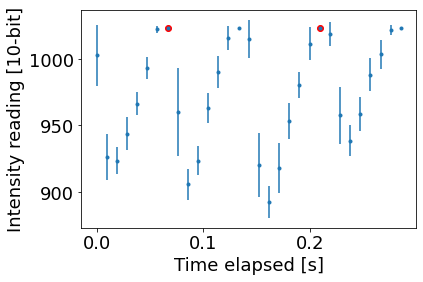

Period: 0.1427378964941569 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


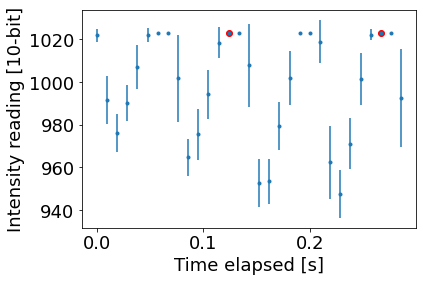

Period: 0.14273789649415694 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


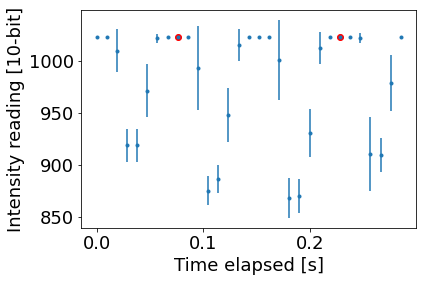

Period: 0.15225375626043408 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


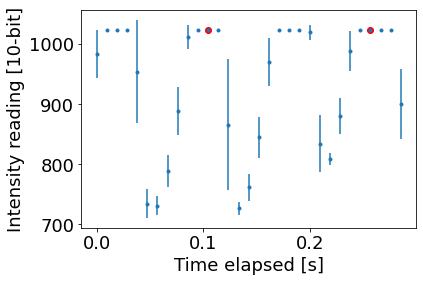

Period: 0.15225375626043405 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


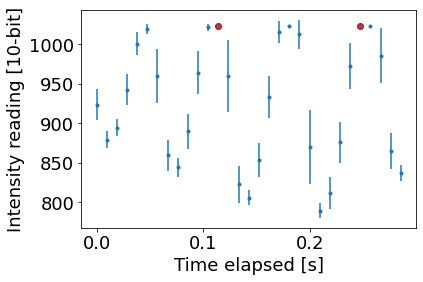

Period: 0.13322203672787977 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


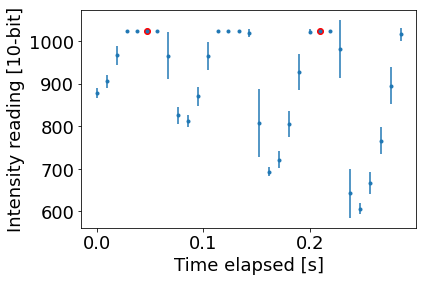

Period: 0.1617696160267112 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


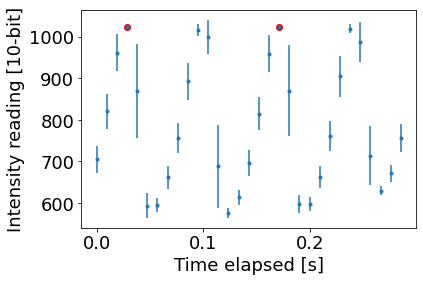

Period: 0.14273789649415694 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


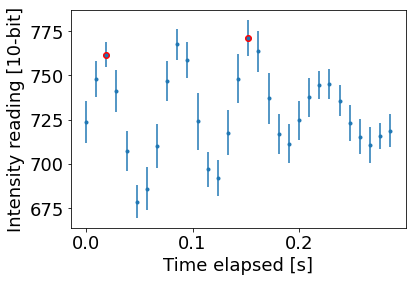

Period: 0.13322203672787977 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


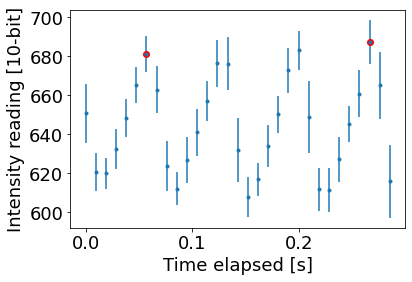

Period: 0.20934891485809684 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


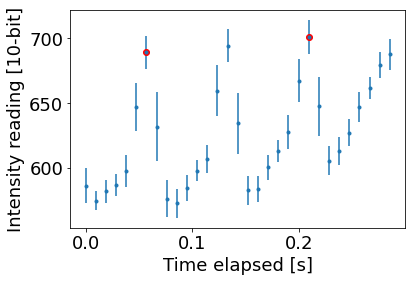

Period: 0.15225375626043405 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


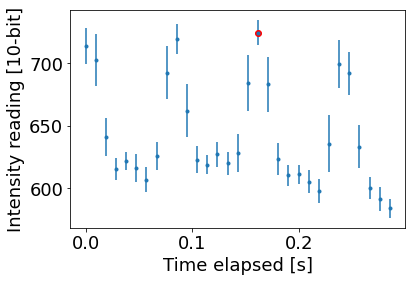

Period: nan +- nan s

0.009515859766277128 nan
31 31


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


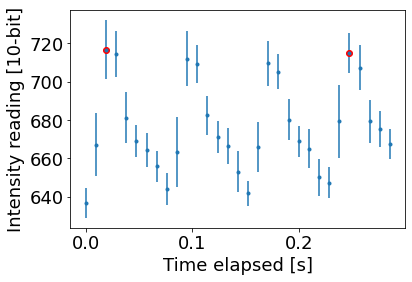

Period: 0.22838063439065107 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


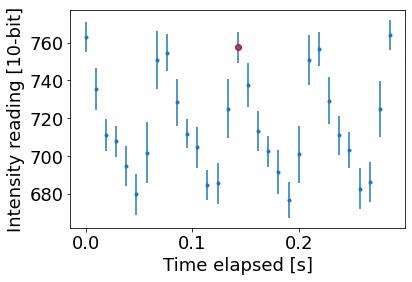

Period: nan +- nan s

0.009515859766277128 nan
31 31


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


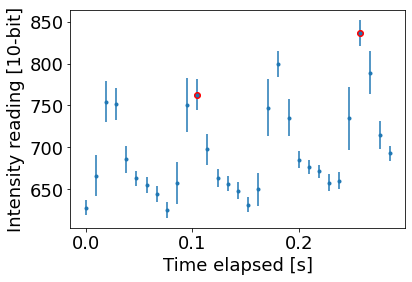

Period: 0.15225375626043405 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


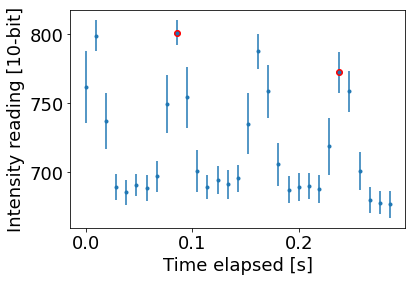

Period: 0.15225375626043405 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


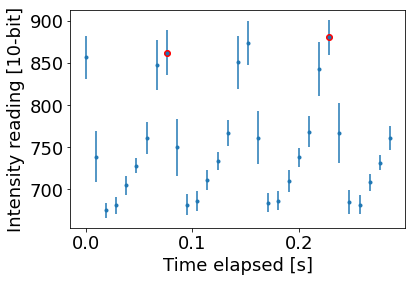

Period: 0.15225375626043408 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


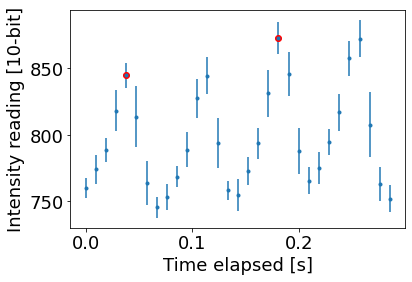

Period: 0.14273789649415694 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


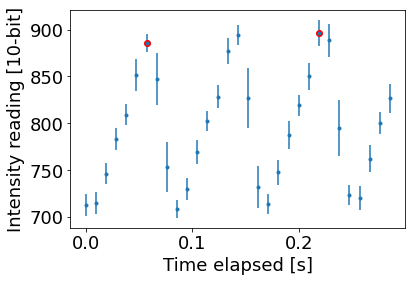

Period: 0.16176961602671117 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


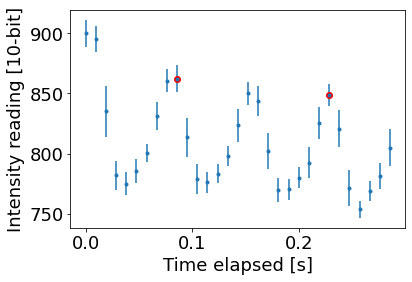

Period: 0.14273789649415694 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


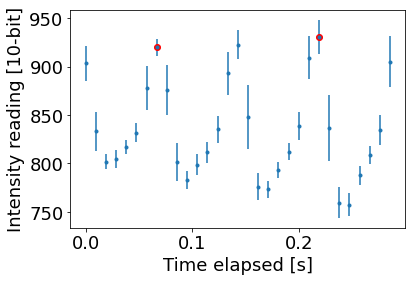

Period: 0.15225375626043405 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


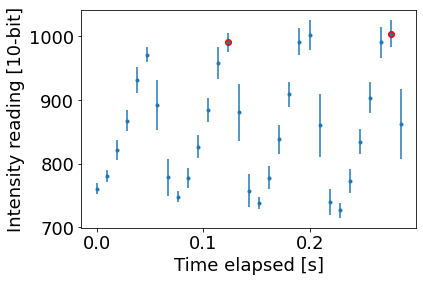

Period: 0.15225375626043408 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


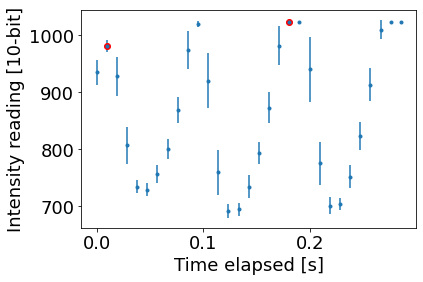

Period: 0.1712854757929883 +- 0.009515859766277128 s

0.009515859766277128 0.0
31 31


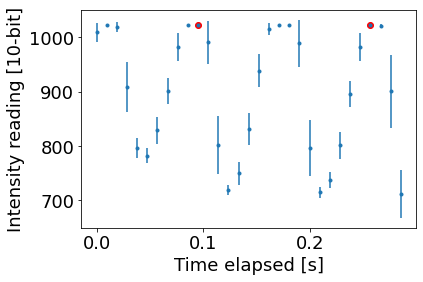

Period: 0.1617696160267112 +- 0.009515859766277128 s

0.009515859766277128 0.0
for factor 19: nan +- nan s
30 30


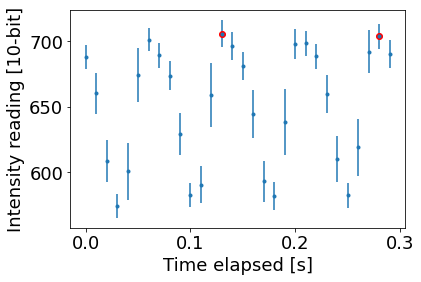

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


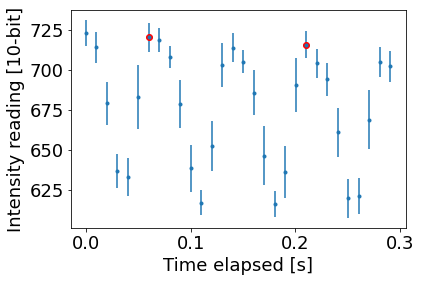

Period: 0.15025041736227043 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


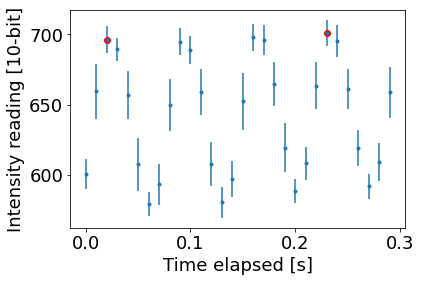

Period: 0.21035058430717865 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


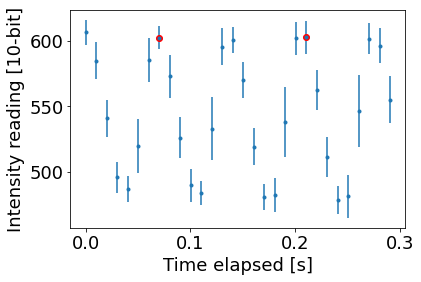

Period: 0.1402337228714524 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


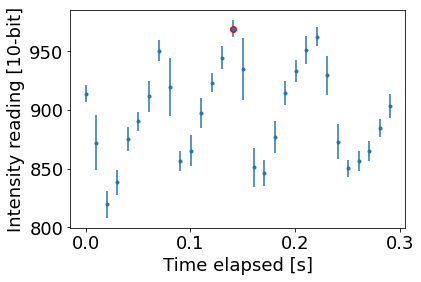

Period: nan +- nan s

0.010016694490818028 nan
30 30


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


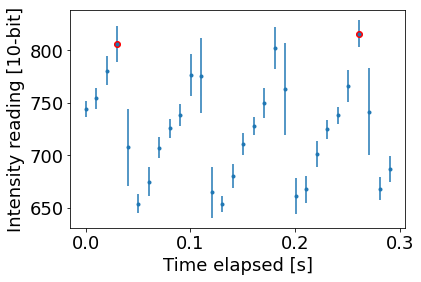

Period: 0.23038397328881471 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


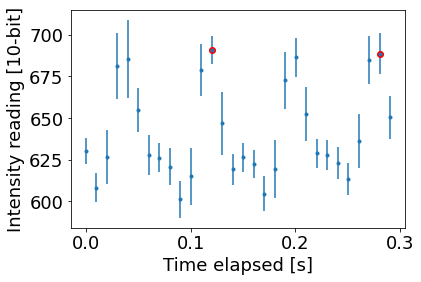

Period: 0.16026711185308848 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


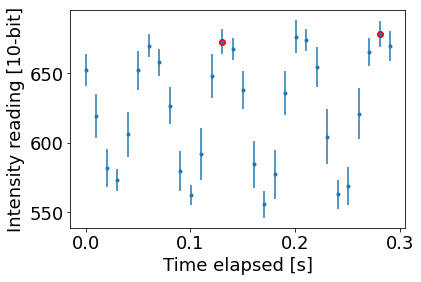

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


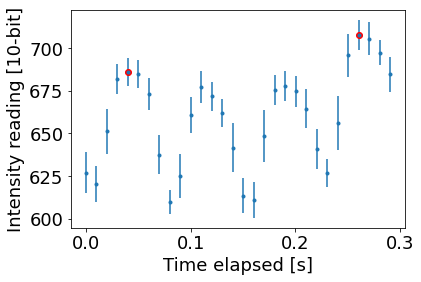

Period: 0.22036727879799667 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


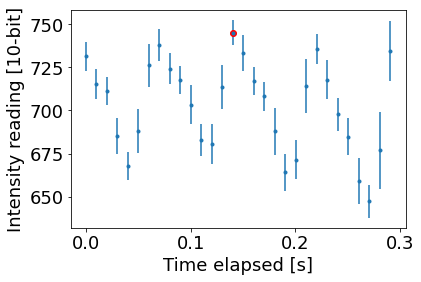

Period: nan +- nan s

0.010016694490818028 nan
30 30


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


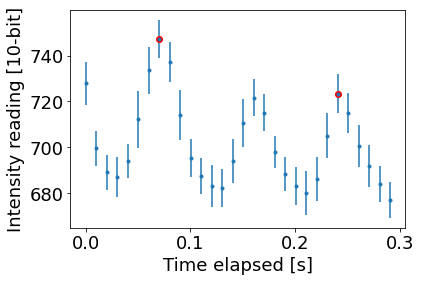

Period: 0.1702838063439065 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


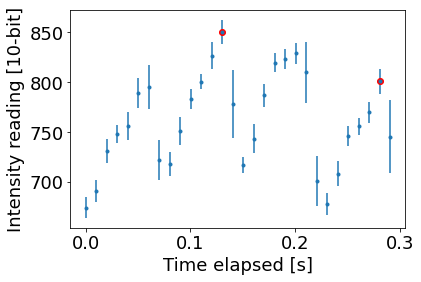

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


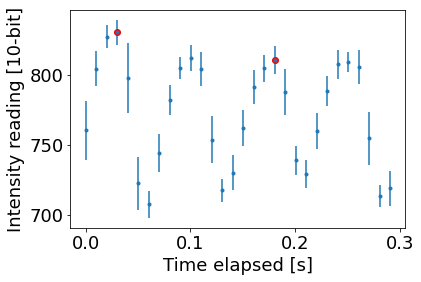

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


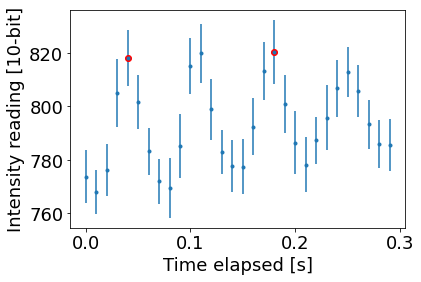

Period: 0.14023372287145242 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


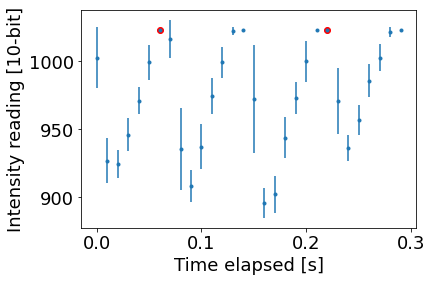

Period: 0.16026711185308845 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


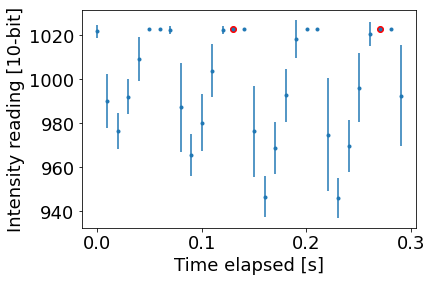

Period: 0.14023372287145244 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


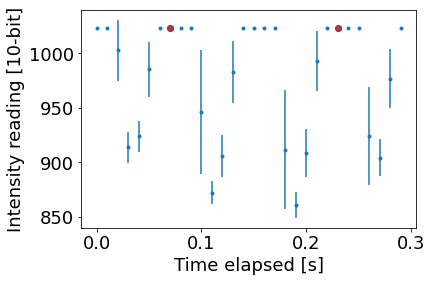

Period: 0.16026711185308848 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


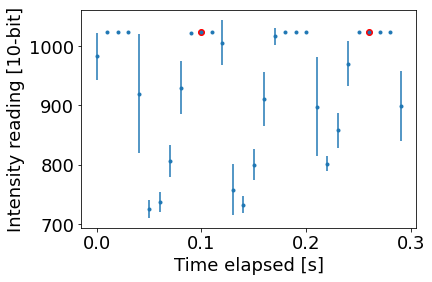

Period: 0.16026711185308848 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


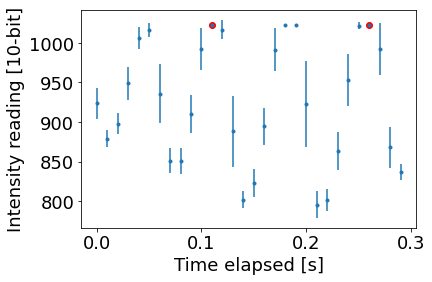

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


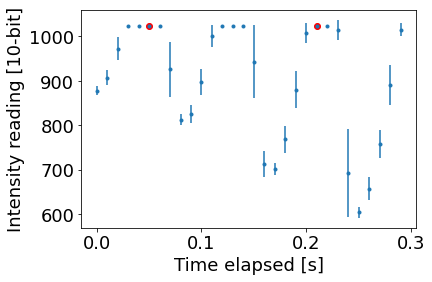

Period: 0.16026711185308848 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


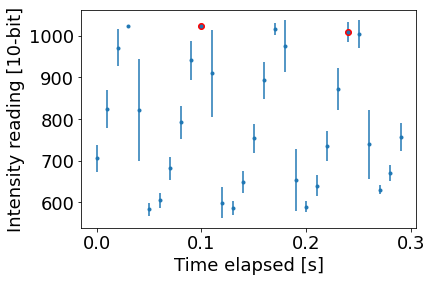

Period: 0.14023372287145242 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


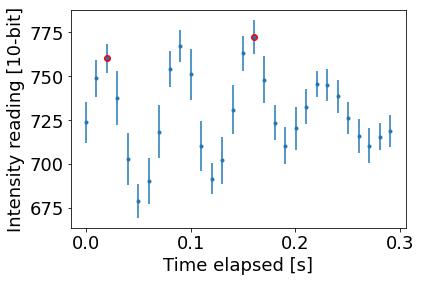

Period: 0.1402337228714524 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


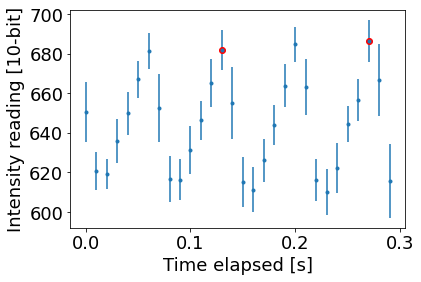

Period: 0.14023372287145244 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


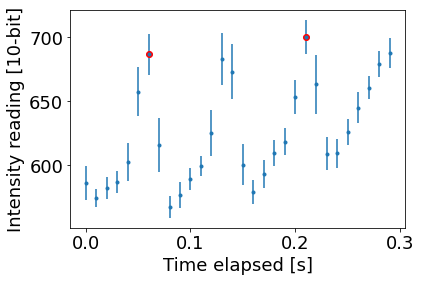

Period: 0.15025041736227043 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


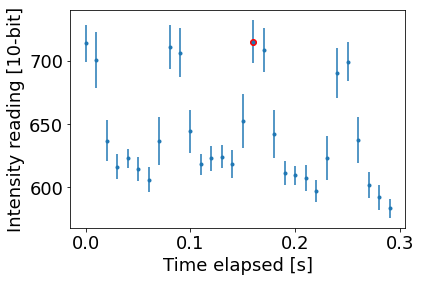

Period: nan +- nan s

0.010016694490818028 nan
30 30


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


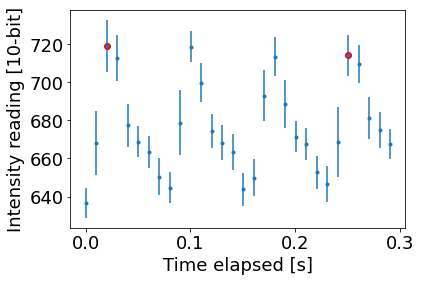

Period: 0.2303839732888147 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


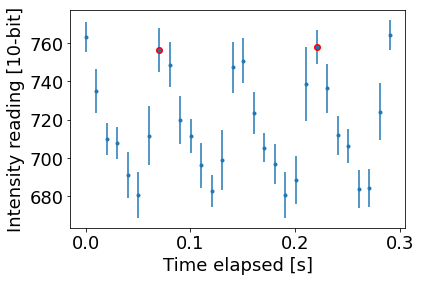

Period: 0.1502504173622704 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


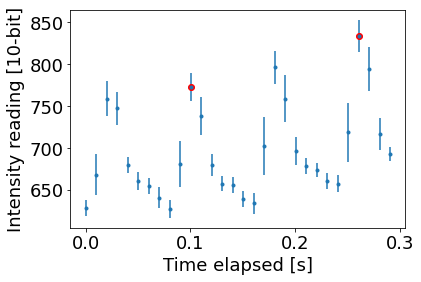

Period: 0.16026711185308848 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


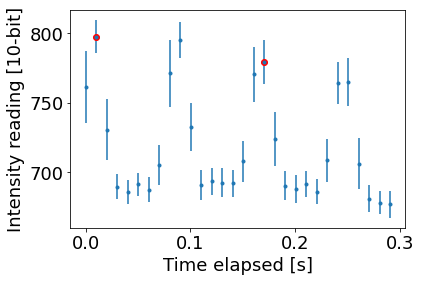

Period: 0.1602671118530885 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


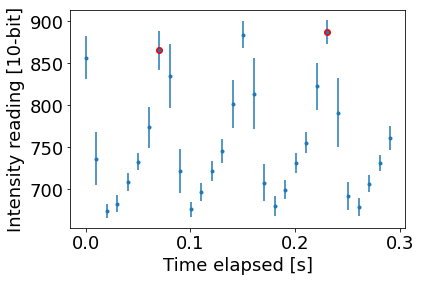

Period: 0.16026711185308848 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


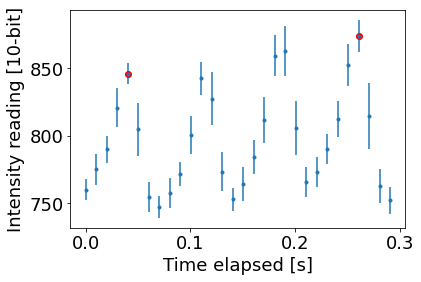

Period: 0.22036727879799667 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


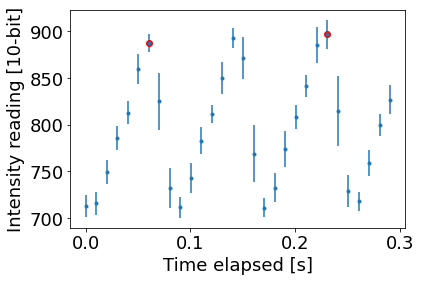

Period: 0.17028380634390652 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


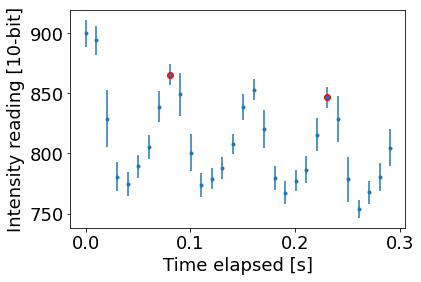

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


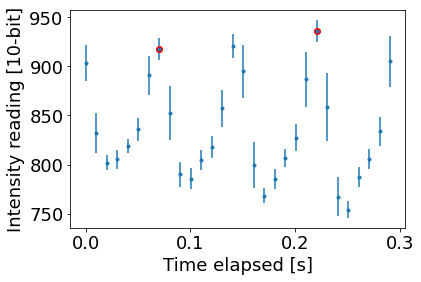

Period: 0.1502504173622704 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


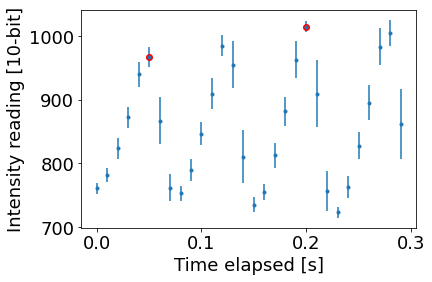

Period: 0.15025041736227046 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


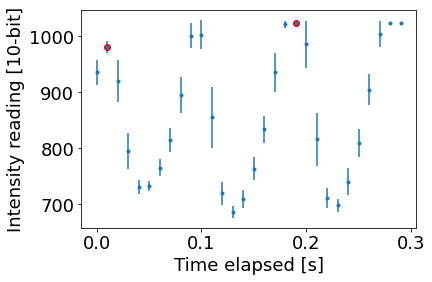

Period: 0.18030050083472454 +- 0.010016694490818028 s

0.010016694490818028 0.0
30 30


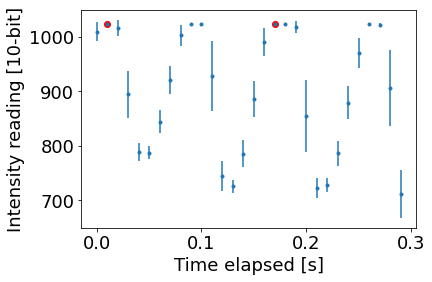

Period: 0.1602671118530885 +- 0.010016694490818028 s

0.010016694490818028 0.0
for factor 20: nan +- nan s
28 28


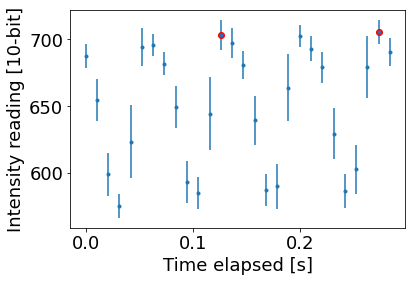

Period: 0.14724540901502506 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


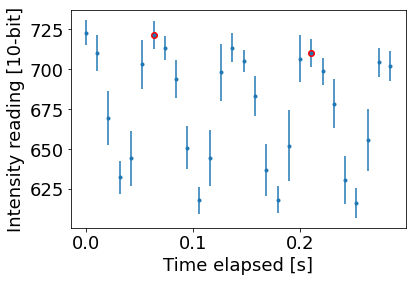

Period: 0.14724540901502503 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


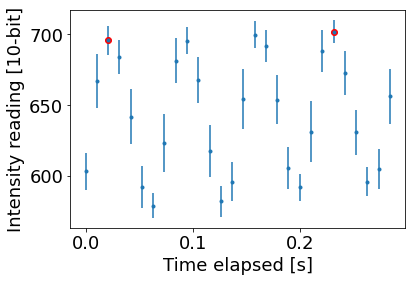

Period: 0.21035058430717862 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


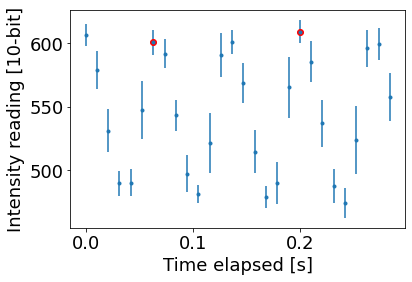

Period: 0.1367278797996661 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


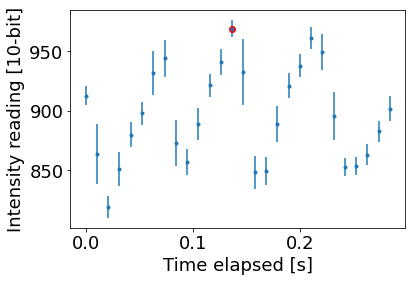

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.010517529215358933 nan
28 28


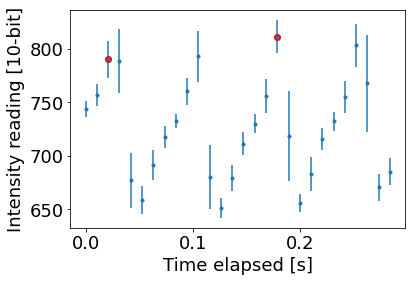

Period: 0.15776293823038395 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


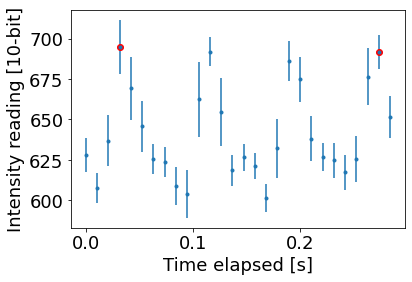

Period: 0.24190317195325542 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


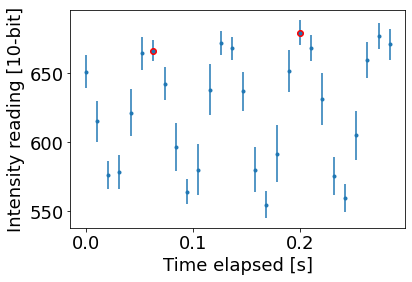

Period: 0.1367278797996661 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


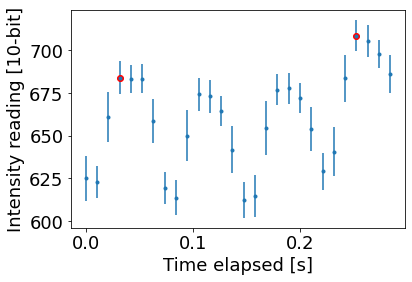

Period: 0.22086811352253755 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


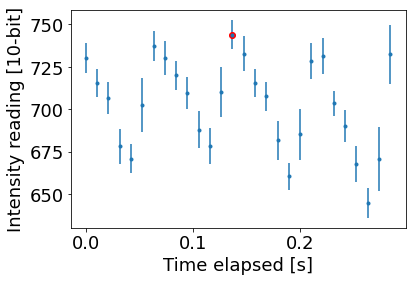

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.010517529215358933 nan
28 28


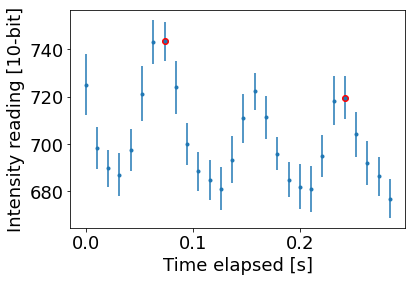

Period: 0.16828046744574293 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


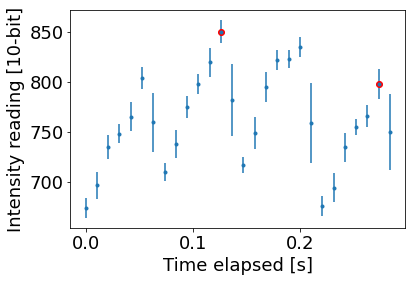

Period: 0.14724540901502506 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


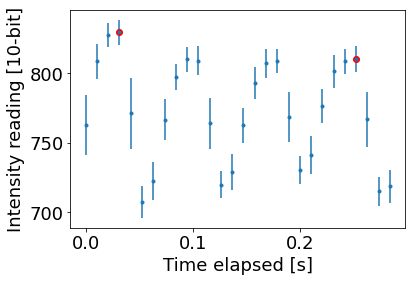

Period: 0.22086811352253755 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


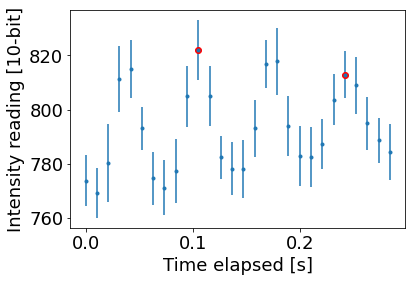

Period: 0.1367278797996661 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


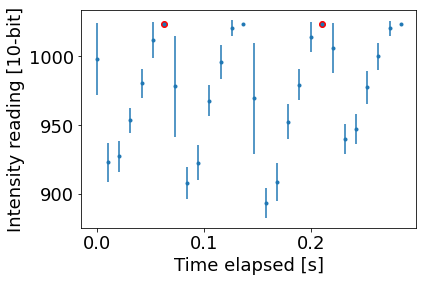

Period: 0.14724540901502503 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


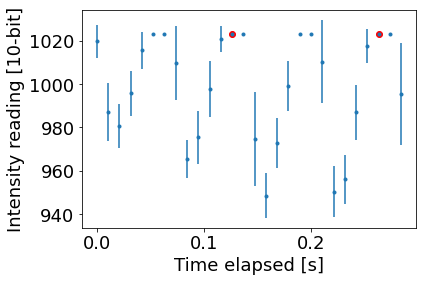

Period: 0.1367278797996661 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


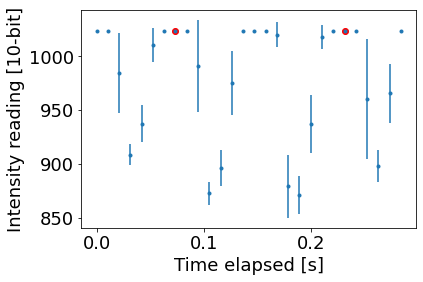

Period: 0.15776293823038395 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


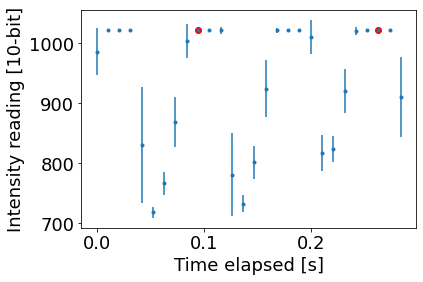

Period: 0.16828046744574293 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


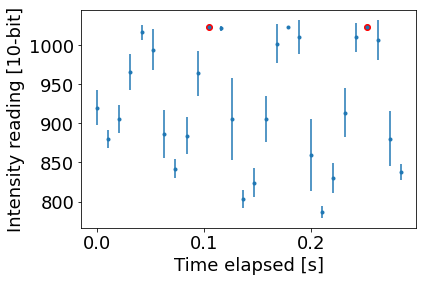

Period: 0.14724540901502503 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


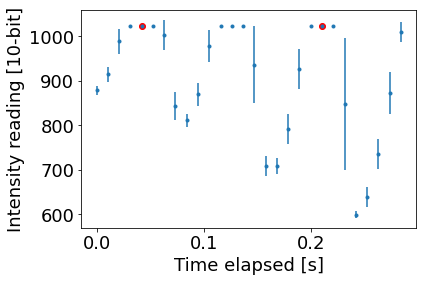

Period: 0.1682804674457429 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


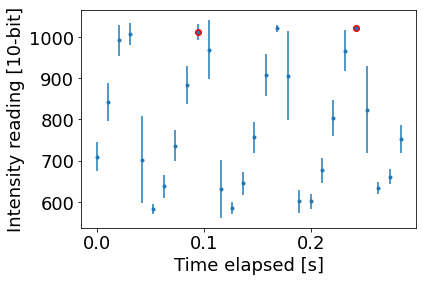

Period: 0.14724540901502506 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


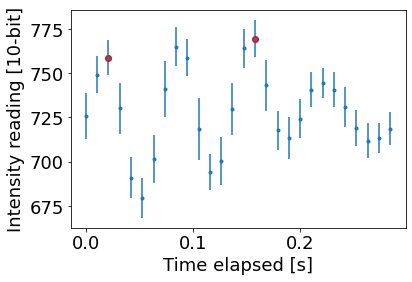

Period: 0.1367278797996661 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


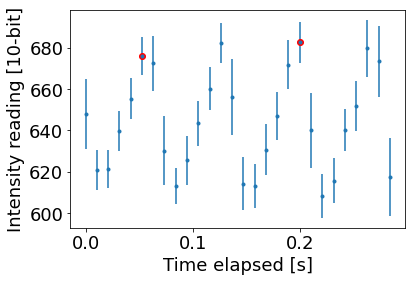

Period: 0.14724540901502503 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


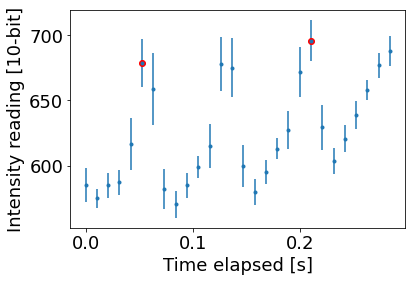

Period: 0.15776293823038395 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


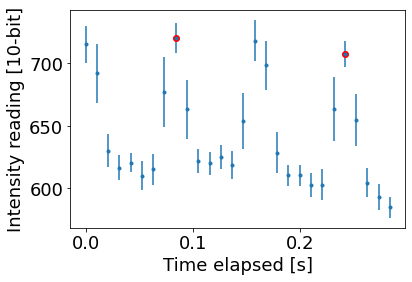

Period: 0.15776293823038395 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


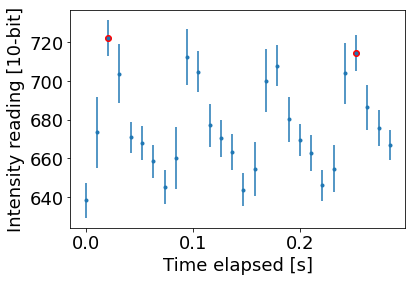

Period: 0.23138564273789647 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


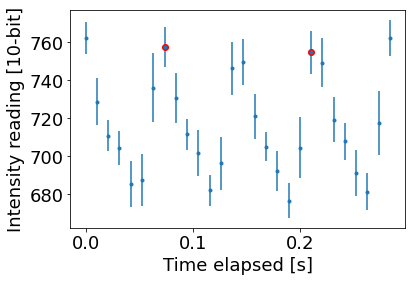

Period: 0.1367278797996661 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


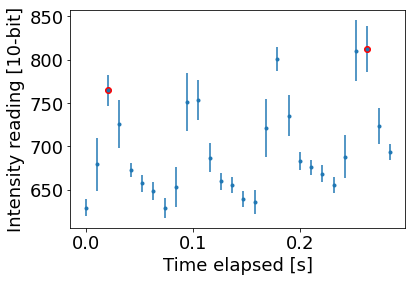

Period: 0.24190317195325542 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


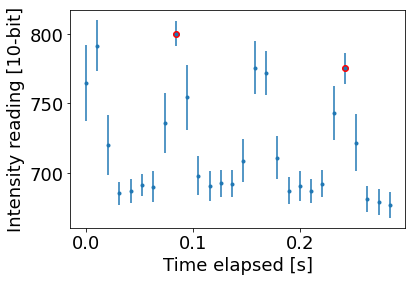

Period: 0.15776293823038395 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


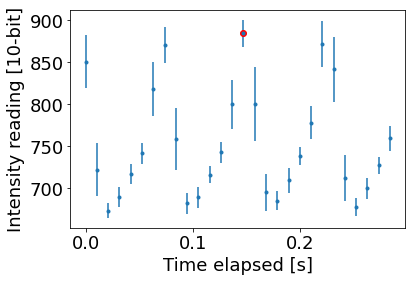

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.010517529215358933 nan
28 28


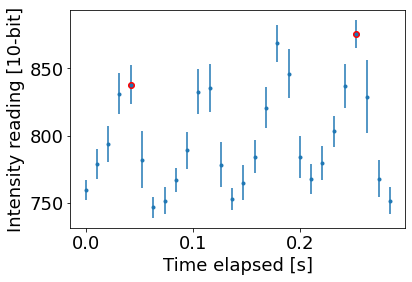

Period: 0.21035058430717862 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


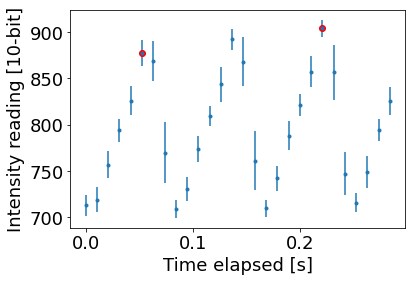

Period: 0.1682804674457429 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


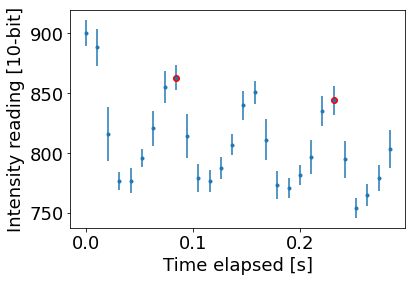

Period: 0.14724540901502503 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


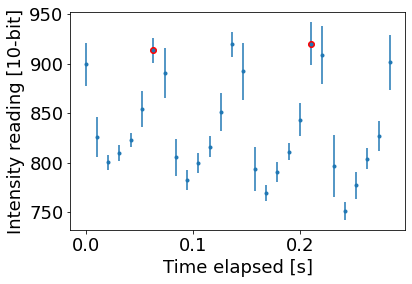

Period: 0.14724540901502503 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


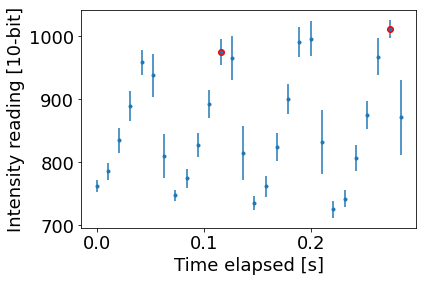

Period: 0.15776293823038395 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


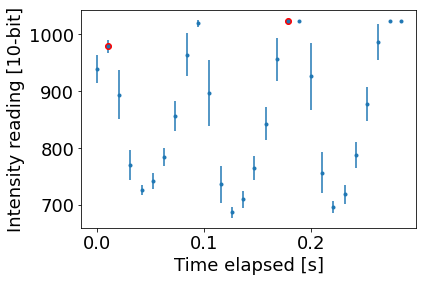

Period: 0.16828046744574293 +- 0.010517529215358933 s

0.010517529215358933 0.0
28 28


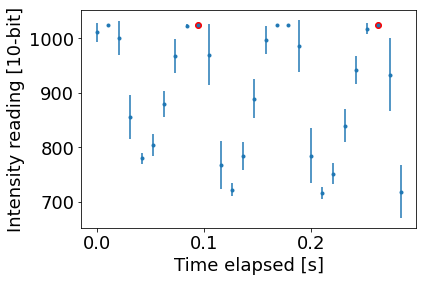

Period: 0.16828046744574293 +- 0.010517529215358933 s

0.010517529215358933 0.0
for factor 21: nan +- nan s
27 27


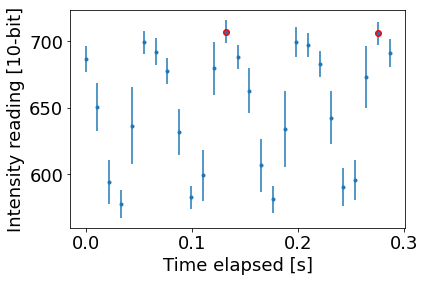

Period: 0.14323873121869782 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


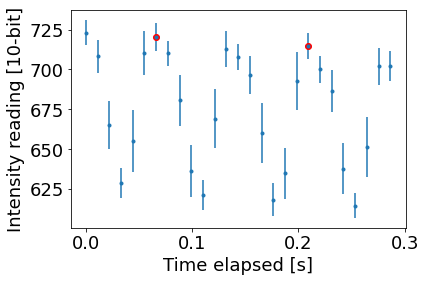

Period: 0.14323873121869785 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


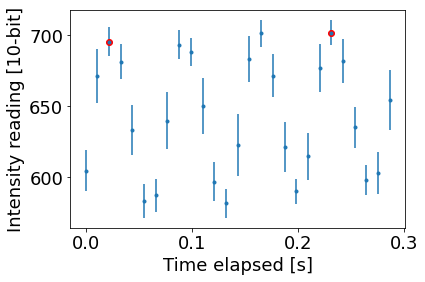

Period: 0.20934891485809684 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


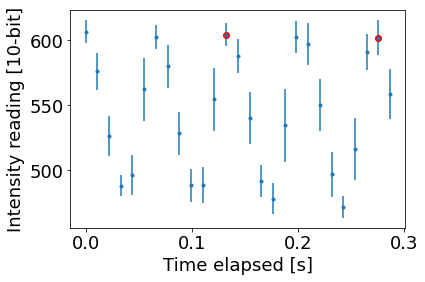

Period: 0.14323873121869782 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


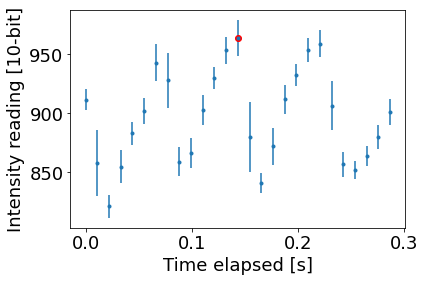

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011018363939899833 nan
27 27


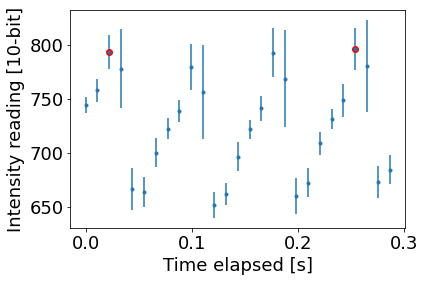

Period: 0.23138564273789647 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


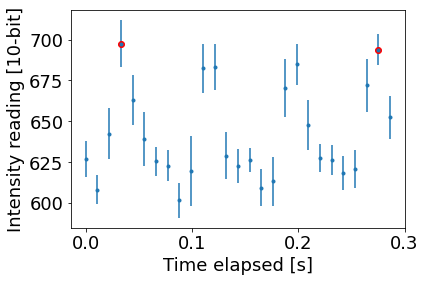

Period: 0.2424040066777963 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


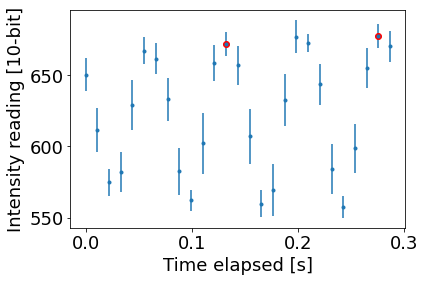

Period: 0.14323873121869782 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


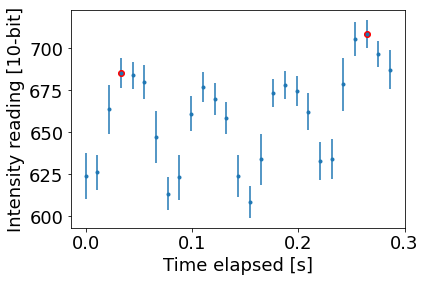

Period: 0.23138564273789647 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


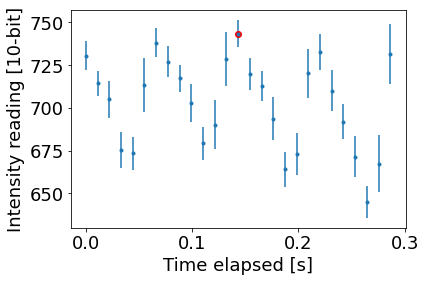

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011018363939899833 nan
27 27


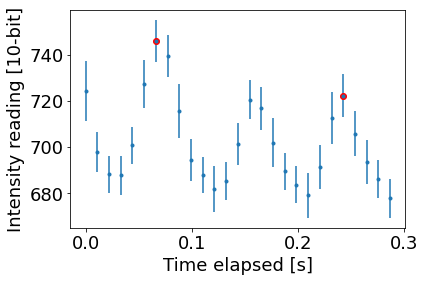

Period: 0.17629382303839736 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


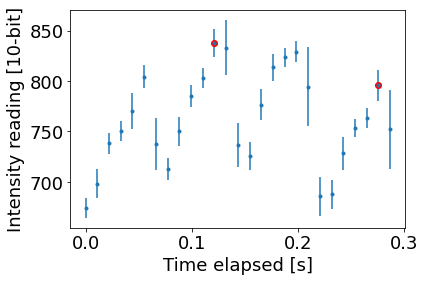

Period: 0.15425709515859762 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


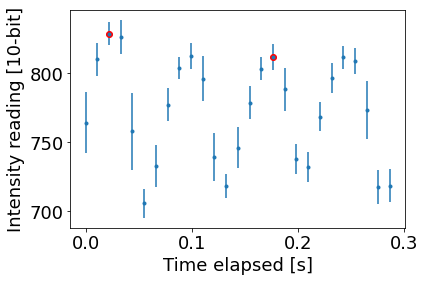

Period: 0.15425709515859765 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


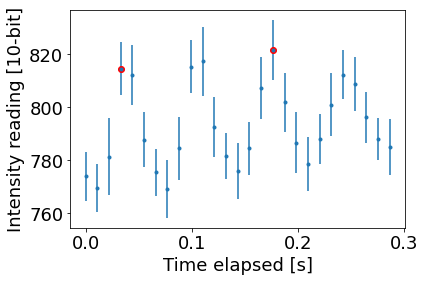

Period: 0.14323873121869782 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


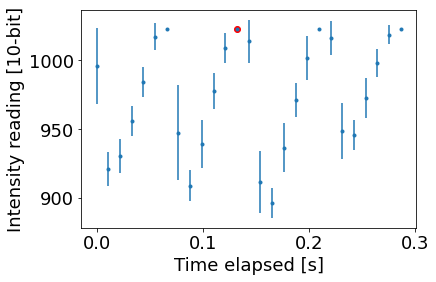

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011018363939899833 nan
27 27


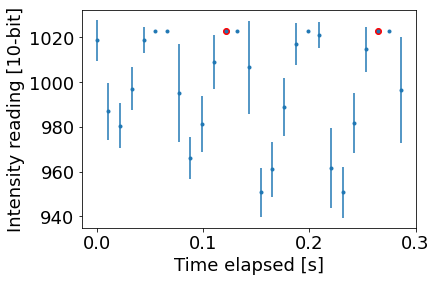

Period: 0.1432387312186978 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


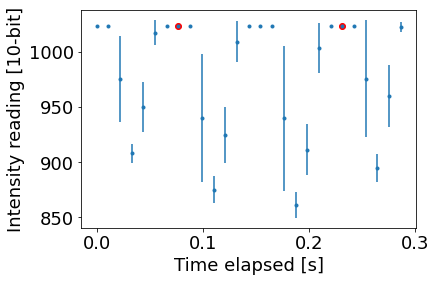

Period: 0.15425709515859767 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


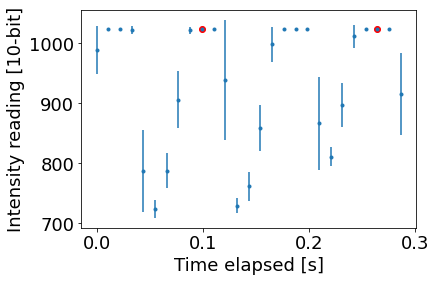

Period: 0.16527545909849747 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


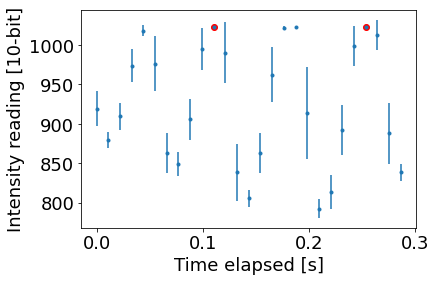

Period: 0.14323873121869782 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


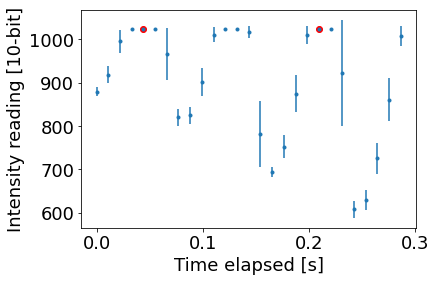

Period: 0.1652754590984975 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


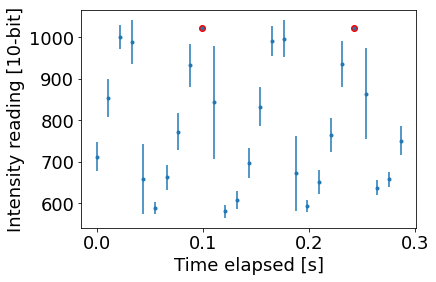

Period: 0.14323873121869785 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


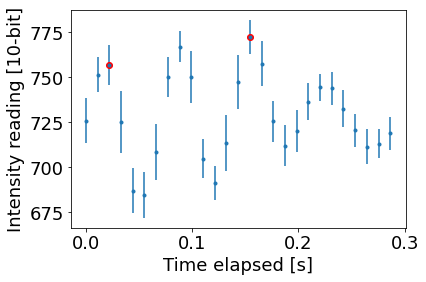

Period: 0.132220367278798 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


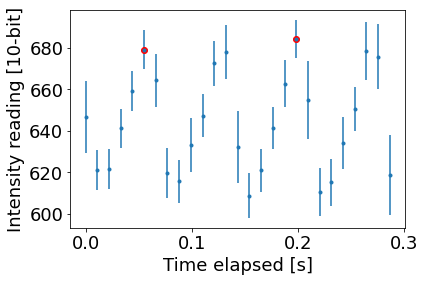

Period: 0.14323873121869785 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


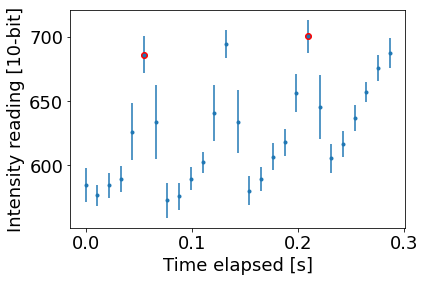

Period: 0.15425709515859767 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


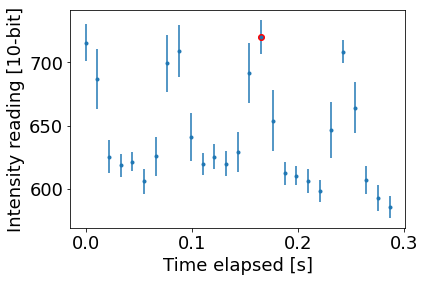

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011018363939899833 nan
27 27


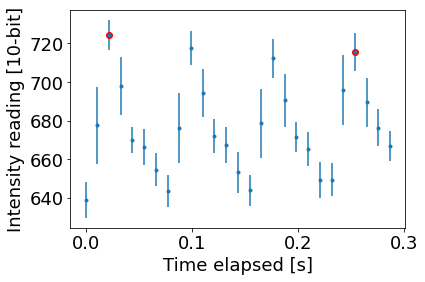

Period: 0.23138564273789647 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


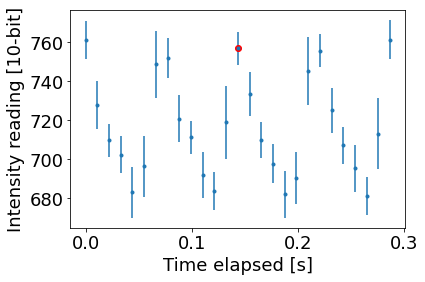

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011018363939899833 nan
27 27


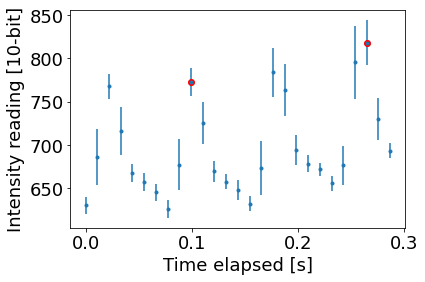

Period: 0.16527545909849747 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


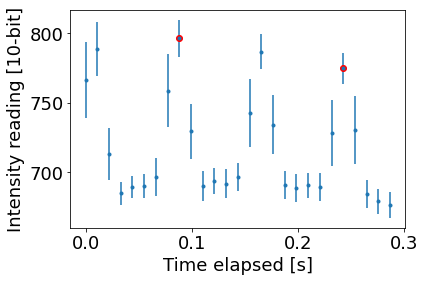

Period: 0.15425709515859767 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


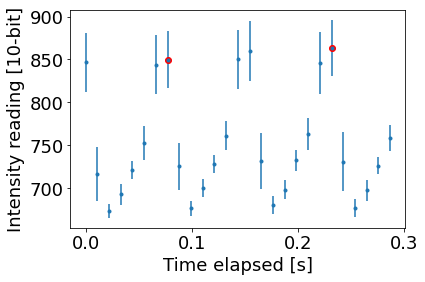

Period: 0.15425709515859767 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


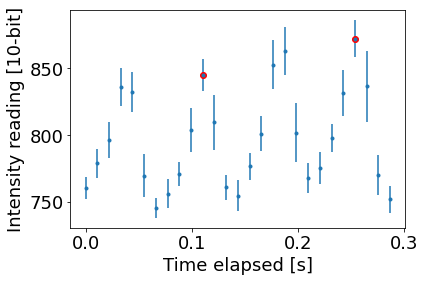

Period: 0.14323873121869782 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


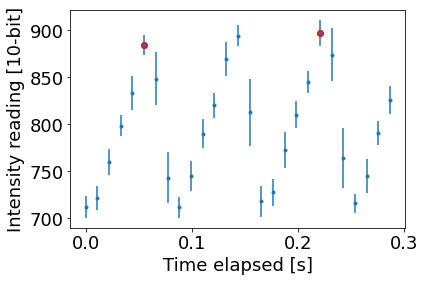

Period: 0.16527545909849747 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


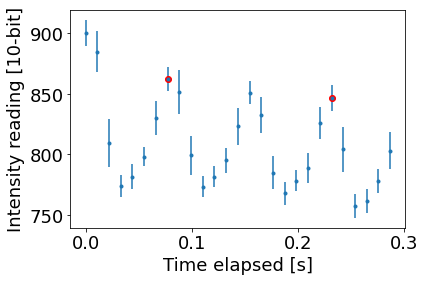

Period: 0.15425709515859767 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


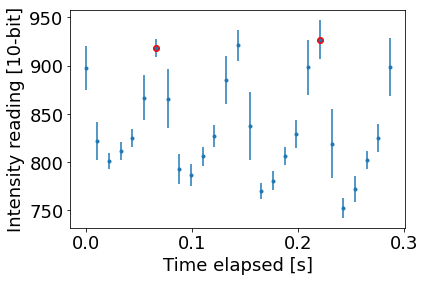

Period: 0.15425709515859762 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


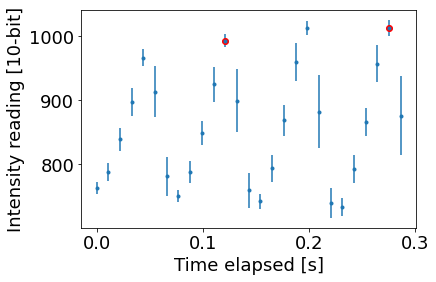

Period: 0.15425709515859762 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


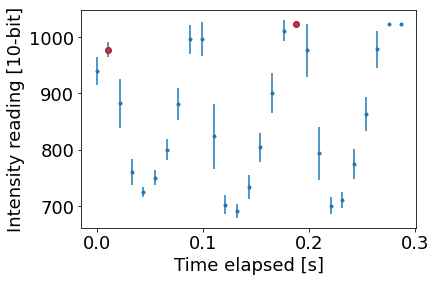

Period: 0.17629382303839733 +- 0.011018363939899833 s

0.011018363939899833 0.0
27 27


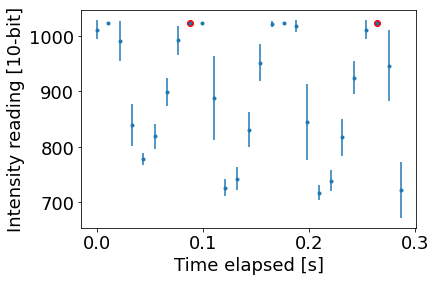

Period: 0.1762938230383973 +- 0.011018363939899833 s

0.011018363939899833 0.0
for factor 22: nan +- nan s
26 26


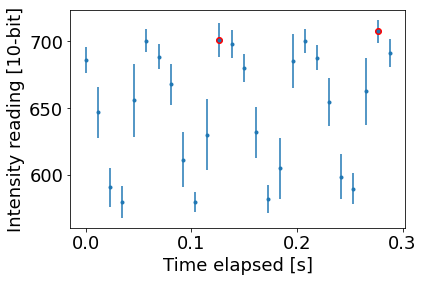

Period: 0.14974958263772956 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


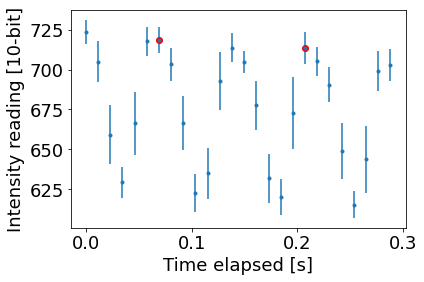

Period: 0.13823038397328882 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


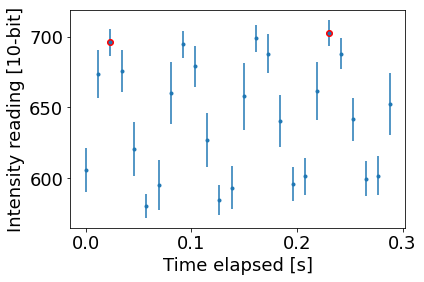

Period: 0.20734557595993325 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


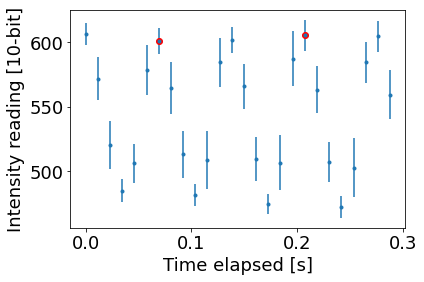

Period: 0.13823038397328882 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


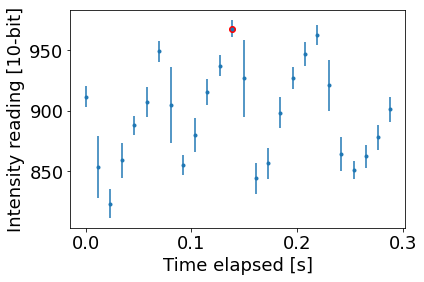

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011519198664440735 nan
26 26


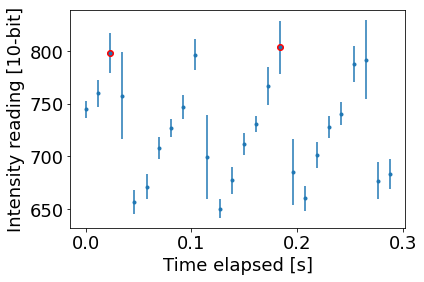

Period: 0.16126878130217032 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


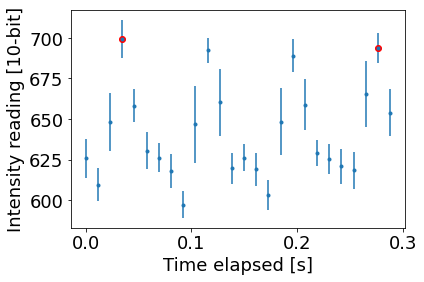

Period: 0.24190317195325542 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


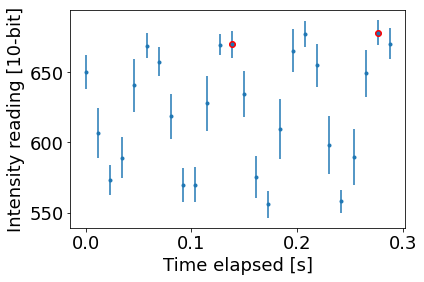

Period: 0.13823038397328882 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


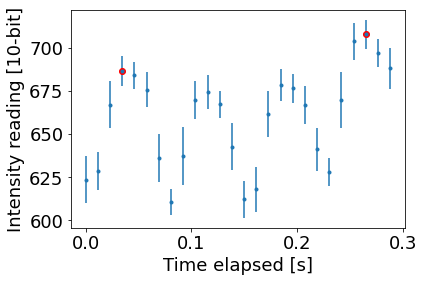

Period: 0.23038397328881466 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


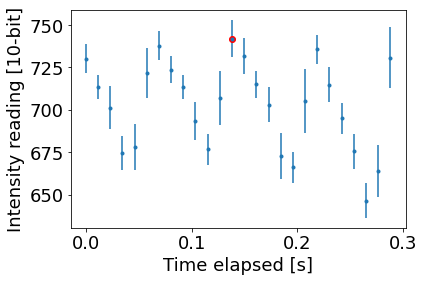

Period: nan +- nan s

0.011519198664440735 nan
26 26


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


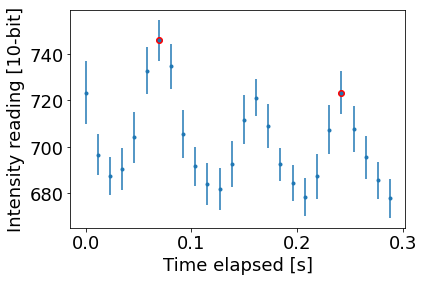

Period: 0.17278797996661102 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


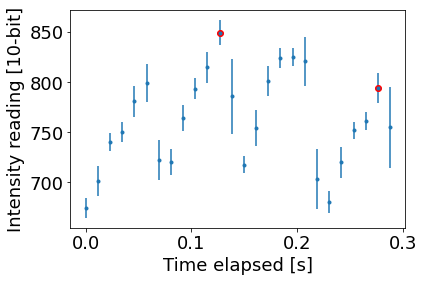

Period: 0.14974958263772956 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


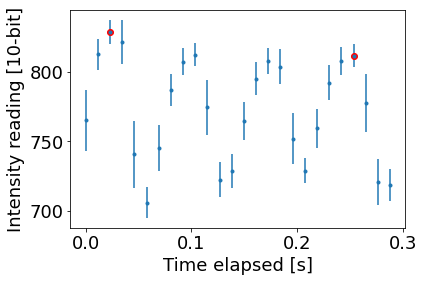

Period: 0.2303839732888147 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


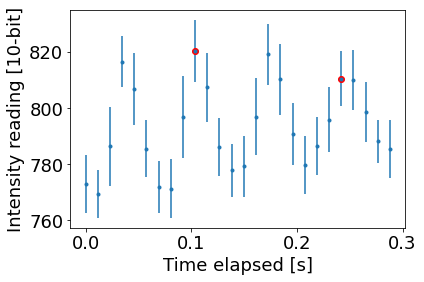

Period: 0.13823038397328882 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


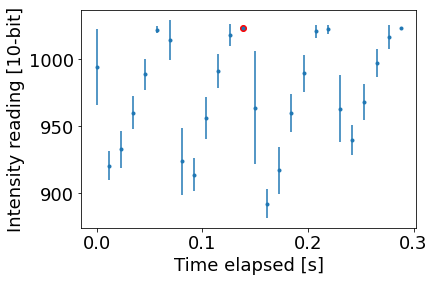

Period: nan +- nan s

0.011519198664440735 nan
26 26


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


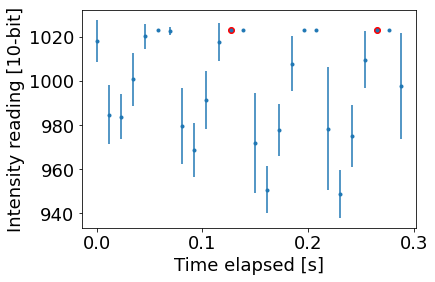

Period: 0.1382303839732888 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


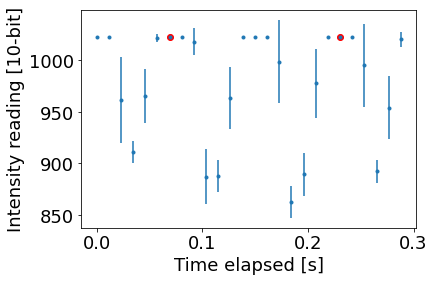

Period: 0.16126878130217032 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


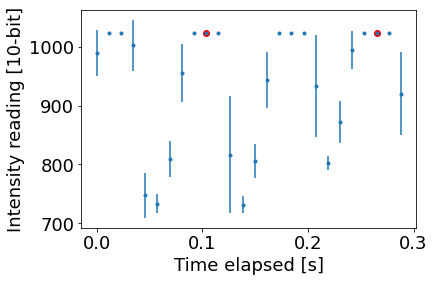

Period: 0.16126878130217023 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


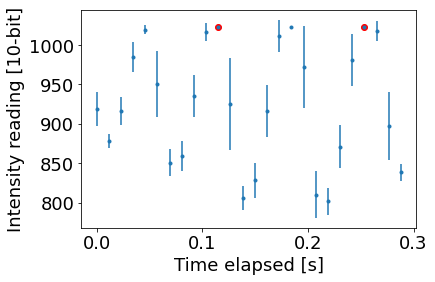

Period: 0.1382303839732888 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


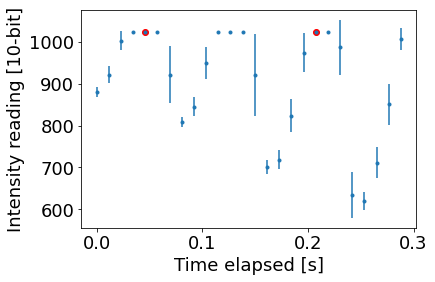

Period: 0.1612687813021703 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


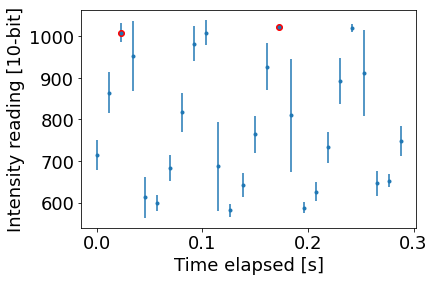

Period: 0.14974958263772953 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


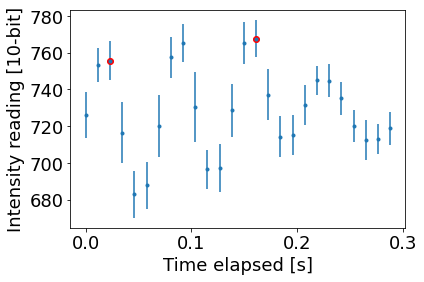

Period: 0.13823038397328882 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


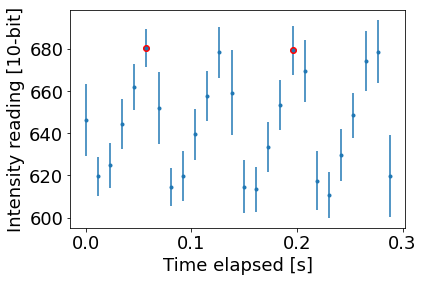

Period: 0.13823038397328882 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


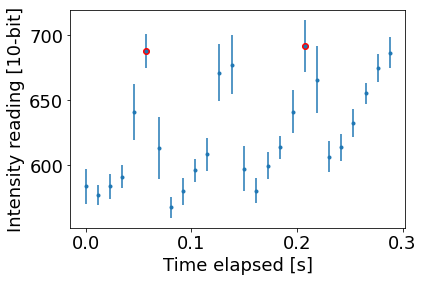

Period: 0.14974958263772953 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


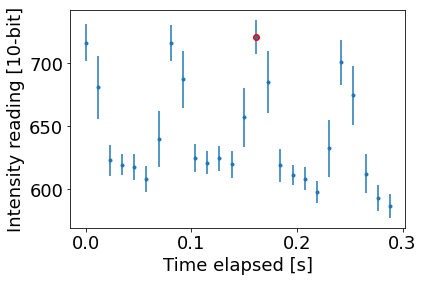

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011519198664440735 nan
26 26


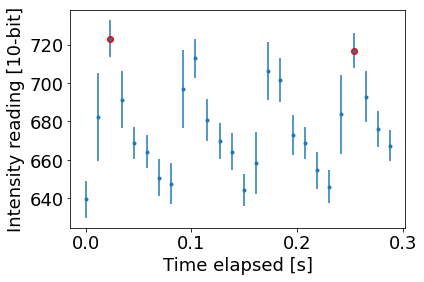

Period: 0.2303839732888147 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


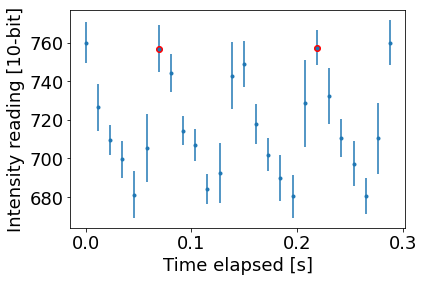

Period: 0.14974958263772953 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


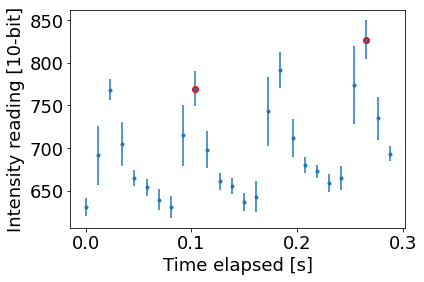

Period: 0.16126878130217023 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


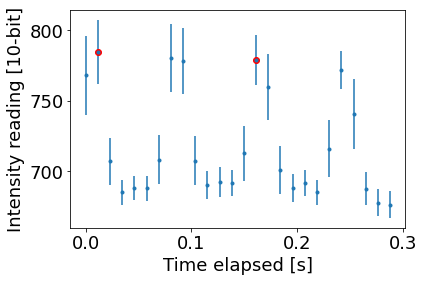

Period: 0.14974958263772953 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


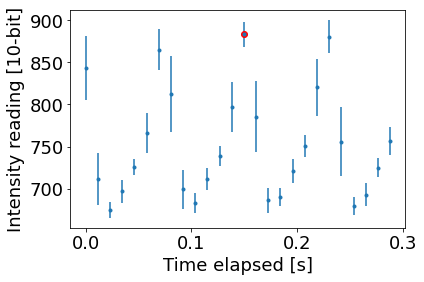

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.011519198664440735 nan
26 26


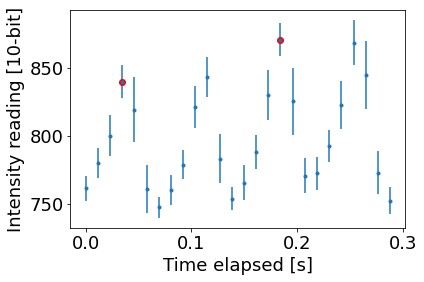

Period: 0.14974958263772956 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


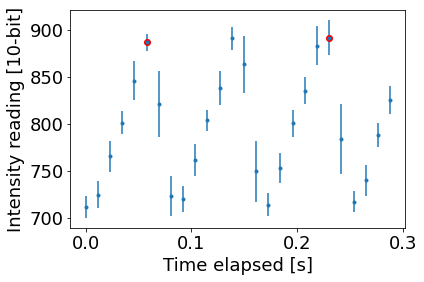

Period: 0.17278797996661102 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


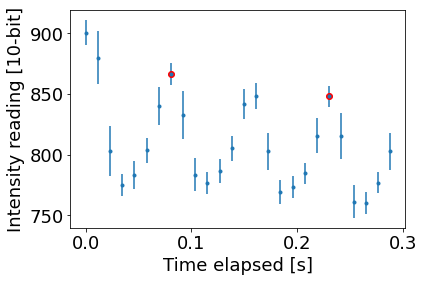

Period: 0.14974958263772958 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


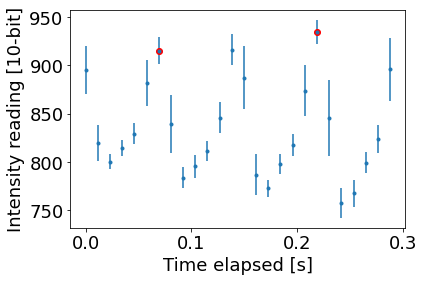

Period: 0.14974958263772953 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


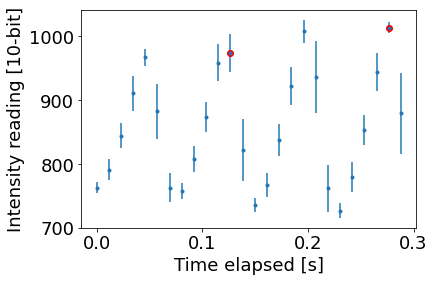

Period: 0.14974958263772956 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


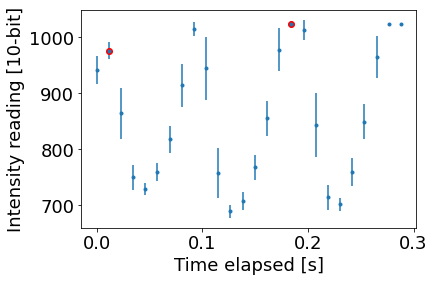

Period: 0.17278797996661102 +- 0.011519198664440735 s

0.011519198664440735 0.0
26 26


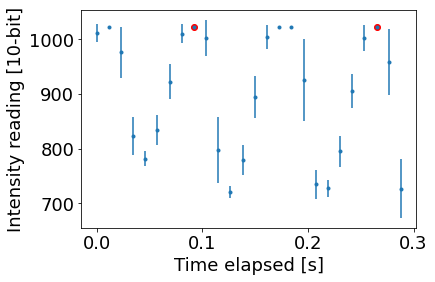

Period: 0.17278797996661097 +- 0.011519198664440735 s

0.011519198664440735 0.0
for factor 23: nan +- nan s
25 25


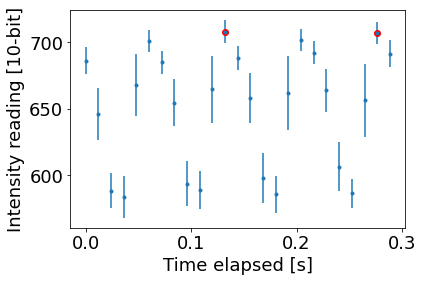

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


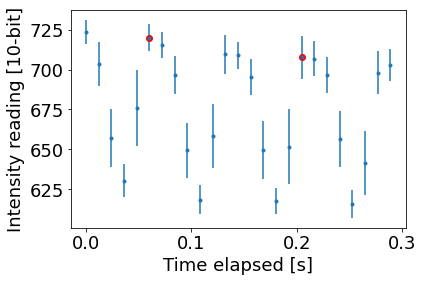

Period: 0.1442404006677796 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


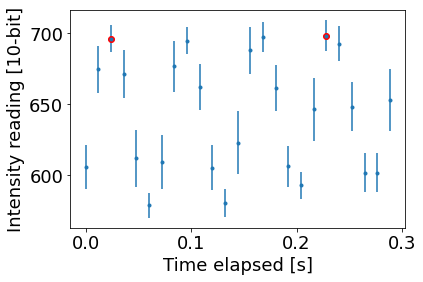

Period: 0.20434056761268782 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


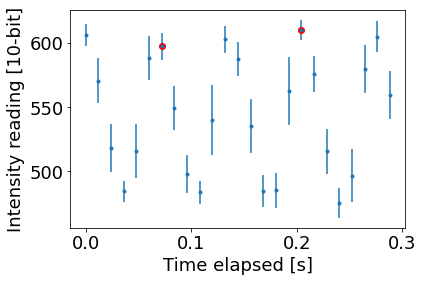

Period: 0.132220367278798 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


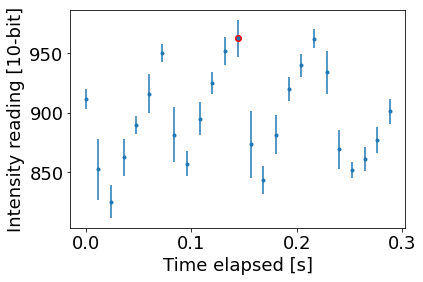

Period: nan +- nan s

0.012020033388981636 nan
25 25


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


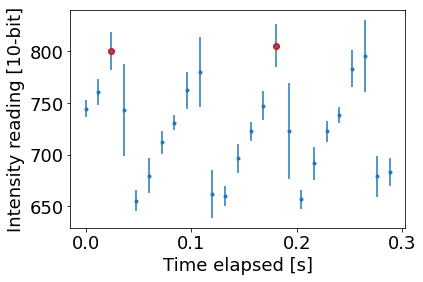

Period: 0.15626043405676127 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


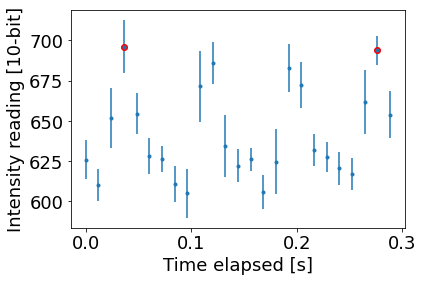

Period: 0.24040066777963273 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


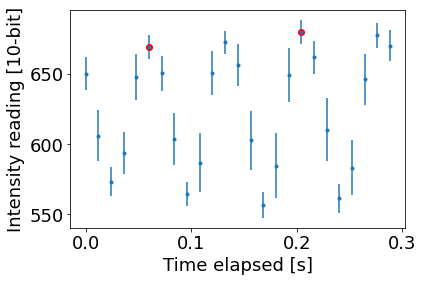

Period: 0.1442404006677796 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


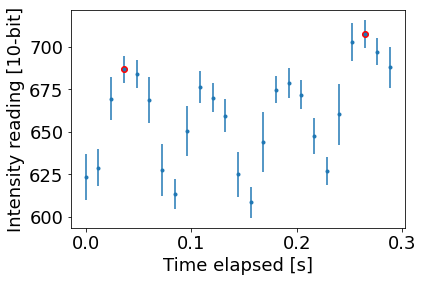

Period: 0.22838063439065107 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


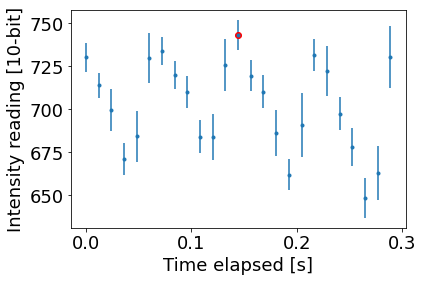

Period: nan +- nan s

0.012020033388981636 nan
25 25


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


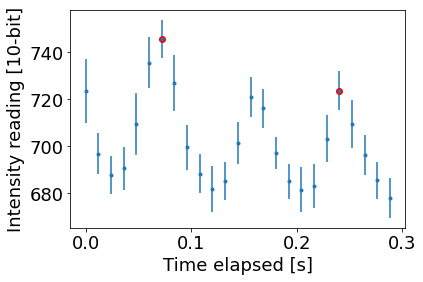

Period: 0.16828046744574293 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


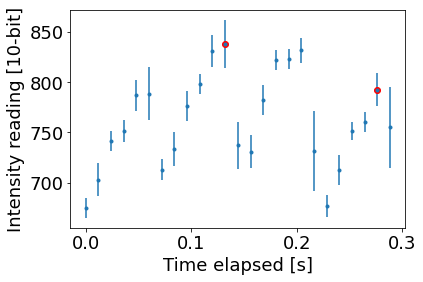

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


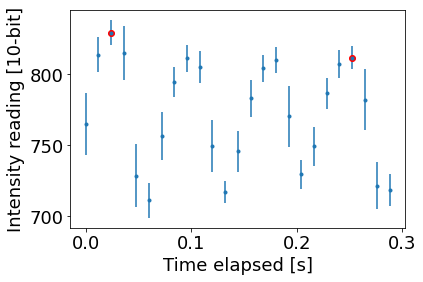

Period: 0.22838063439065107 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


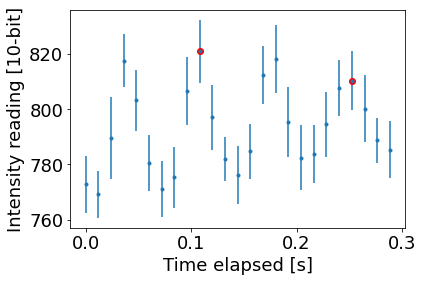

Period: 0.1442404006677796 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


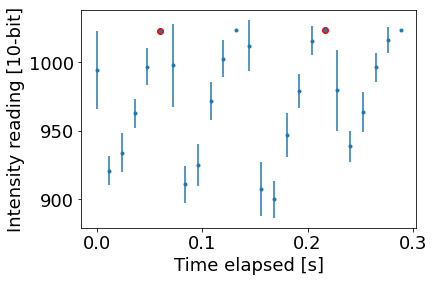

Period: 0.15626043405676127 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


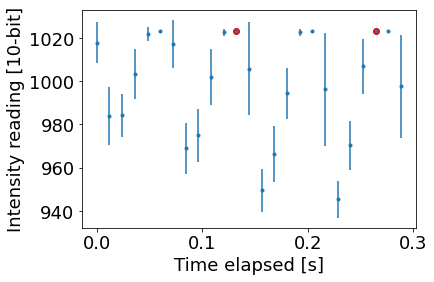

Period: 0.132220367278798 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


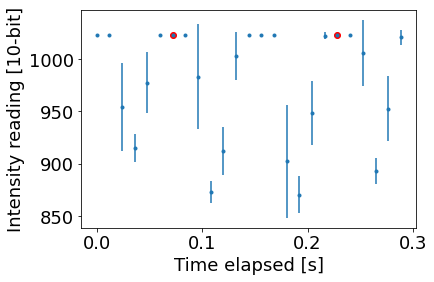

Period: 0.1562604340567613 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


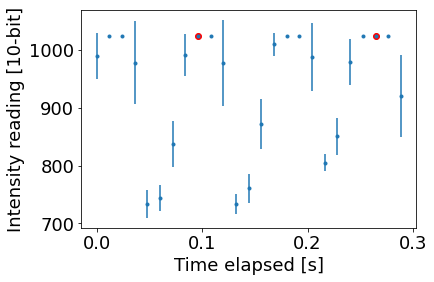

Period: 0.1682804674457429 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


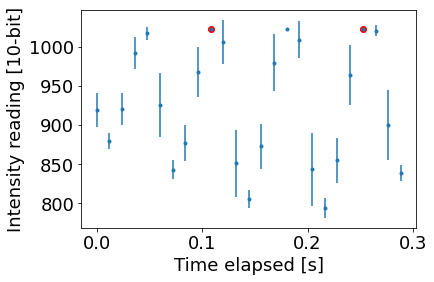

Period: 0.1442404006677796 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


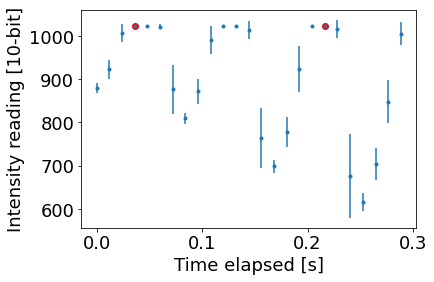

Period: 0.18030050083472454 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


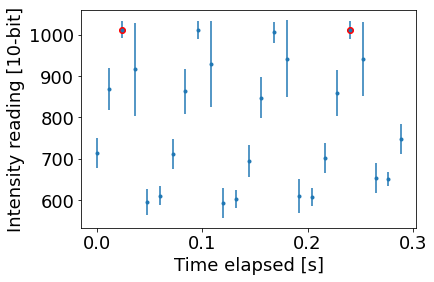

Period: 0.21636060100166946 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


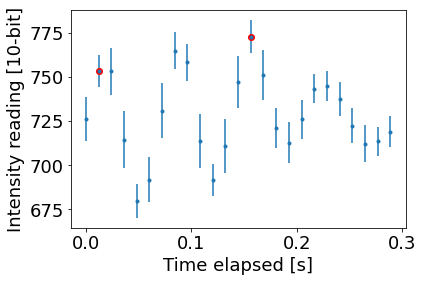

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


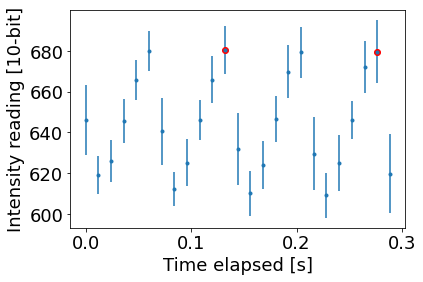

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


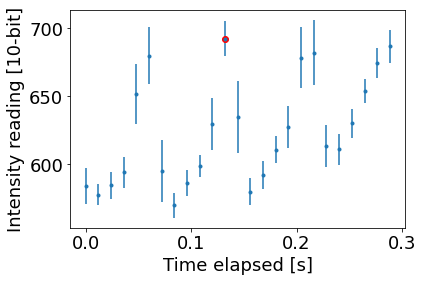

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.012020033388981636 nan
25 25


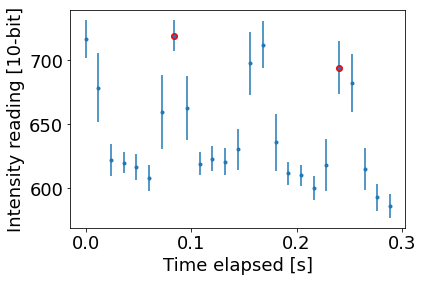

Period: 0.15626043405676127 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


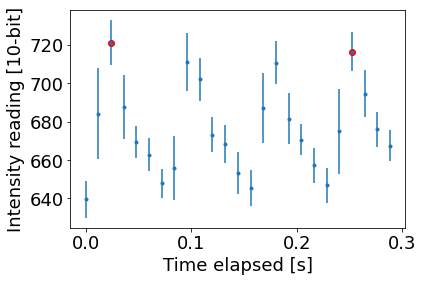

Period: 0.22838063439065107 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


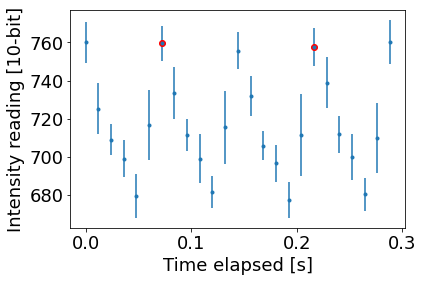

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


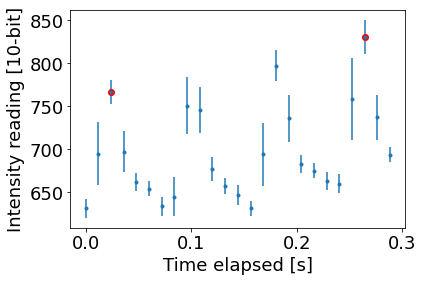

Period: 0.2404006677796327 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


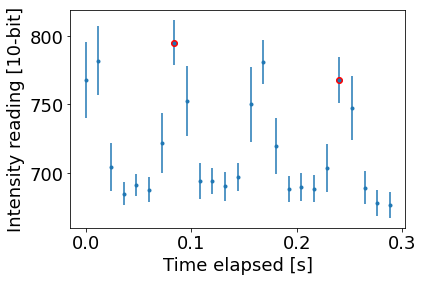

Period: 0.15626043405676127 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


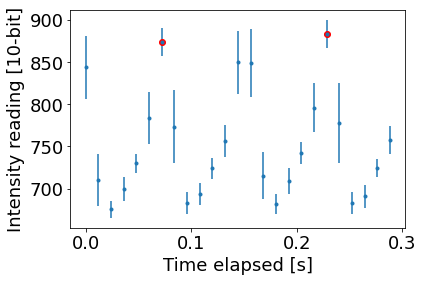

Period: 0.1562604340567613 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


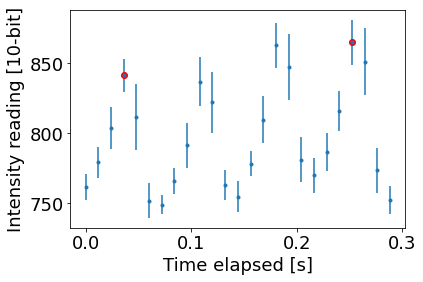

Period: 0.21636060100166946 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


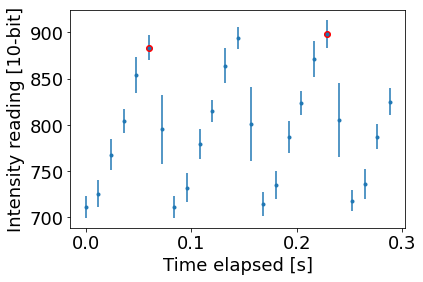

Period: 0.16828046744574293 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


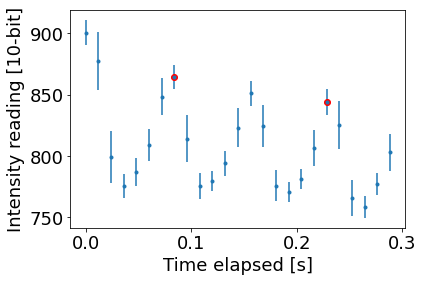

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


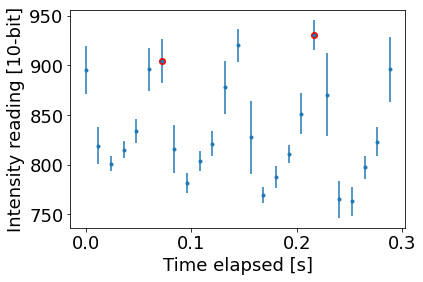

Period: 0.14424040066777966 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


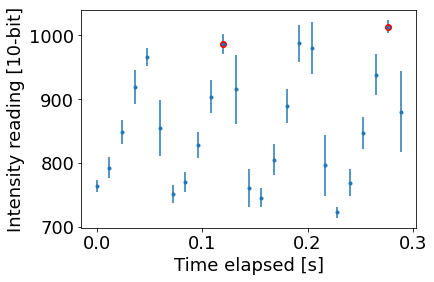

Period: 0.15626043405676127 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


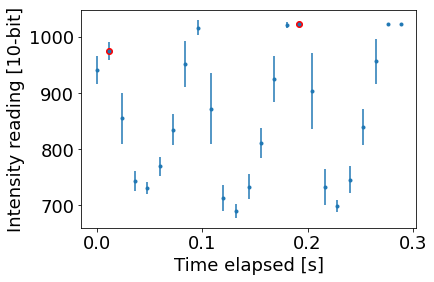

Period: 0.18030050083472454 +- 0.012020033388981636 s

0.012020033388981636 0.0
25 25


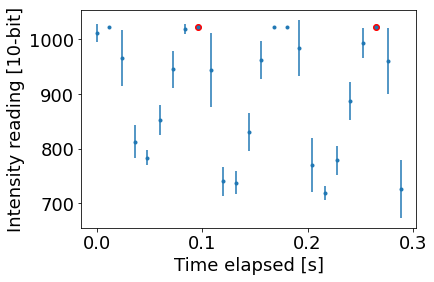

Period: 0.1682804674457429 +- 0.012020033388981636 s

0.012020033388981636 0.0
for factor 24: nan +- nan s
24 24


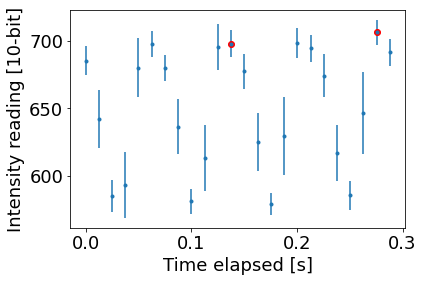

Period: 0.13772954924874792 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


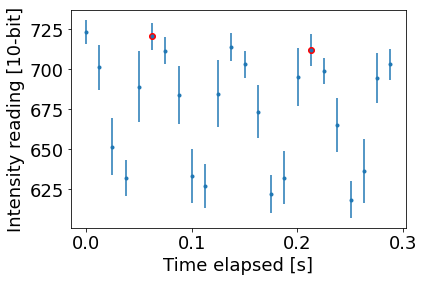

Period: 0.15025041736227046 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


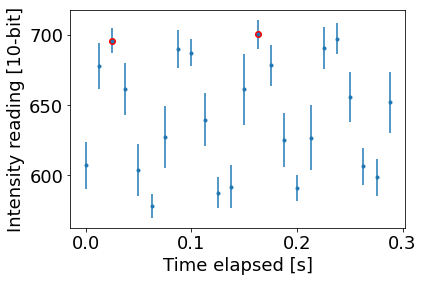

Period: 0.13772954924874792 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


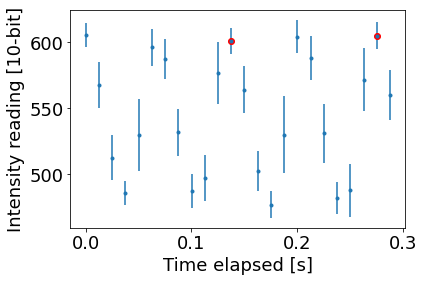

Period: 0.13772954924874792 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


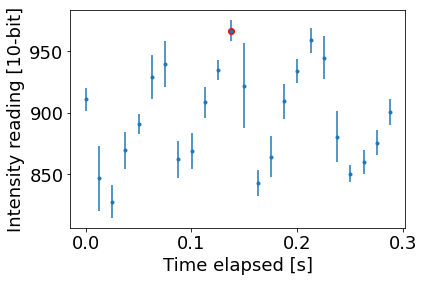

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.012520868113522538 nan
24 24


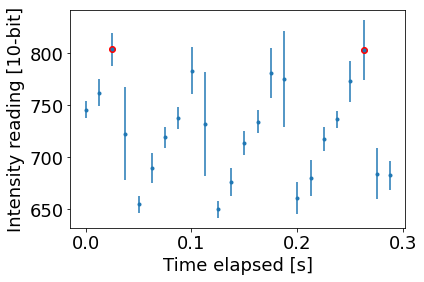

Period: 0.2378964941569282 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


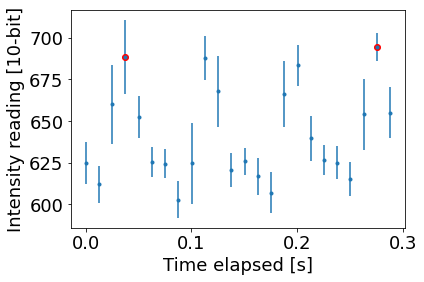

Period: 0.2378964941569282 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


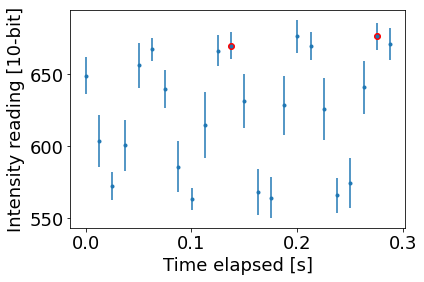

Period: 0.13772954924874792 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


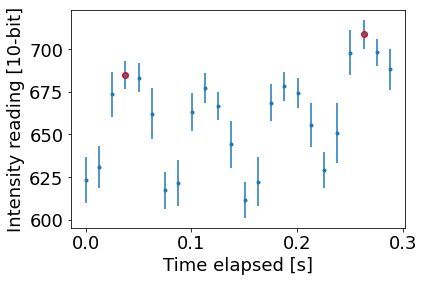

Period: 0.22537562604340566 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


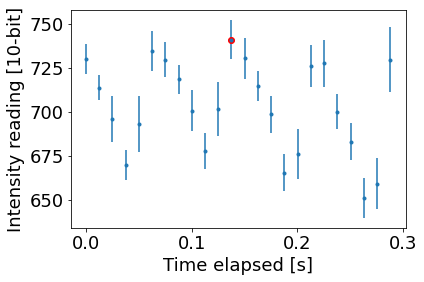

/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Period: nan +- nan s

0.012520868113522538 nan
24 24


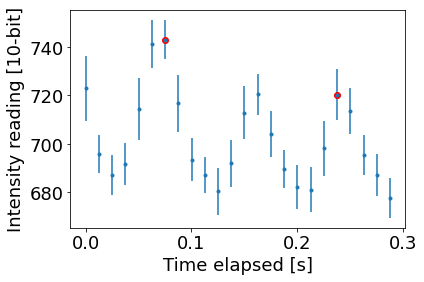

Period: 0.162771285475793 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


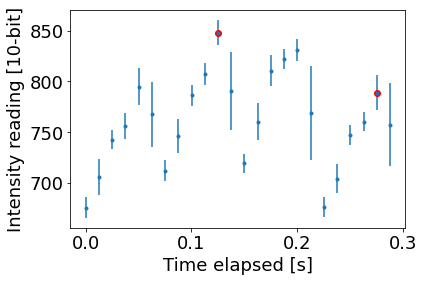

Period: 0.15025041736227043 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


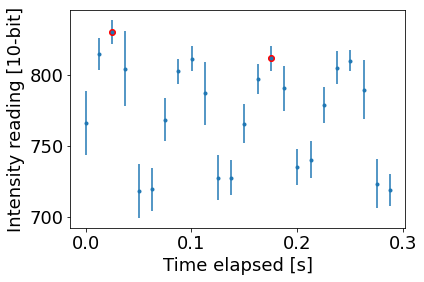

Period: 0.15025041736227043 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


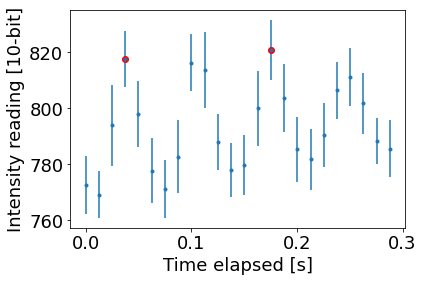

Period: 0.13772954924874792 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


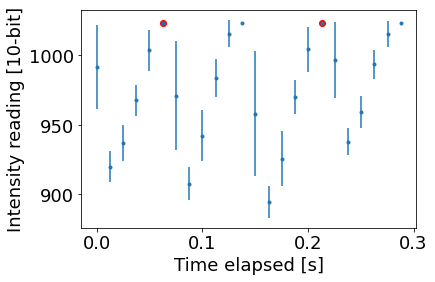

Period: 0.15025041736227046 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


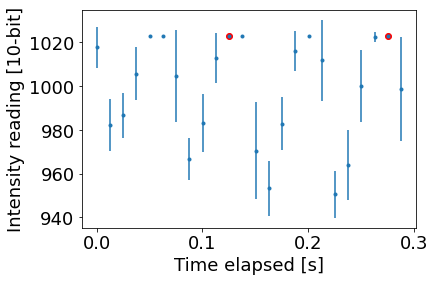

Period: 0.15025041736227043 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


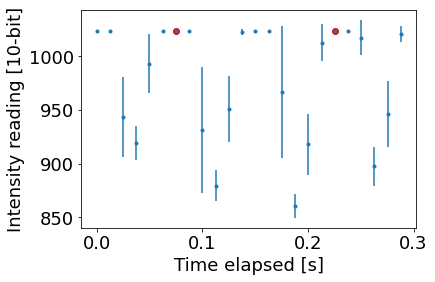

Period: 0.15025041736227046 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


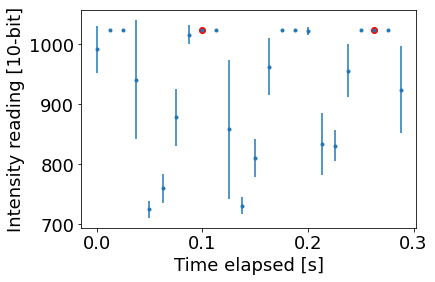

Period: 0.16277128547579298 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


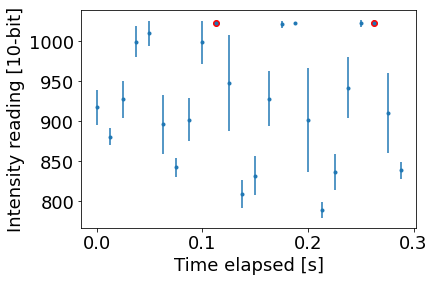

Period: 0.15025041736227043 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


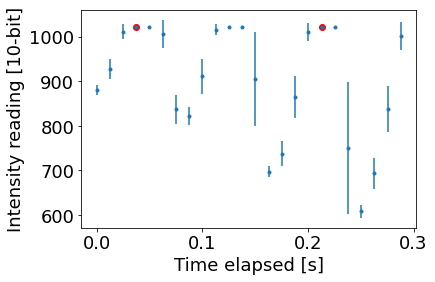

Period: 0.17529215358931555 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


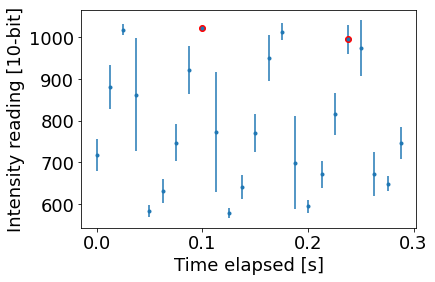

Period: 0.13772954924874792 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


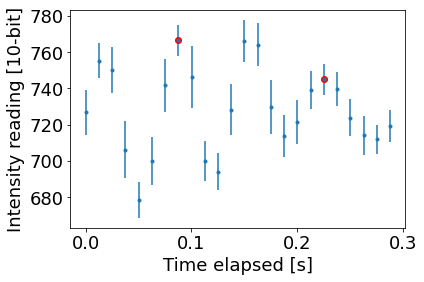

Period: 0.13772954924874795 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


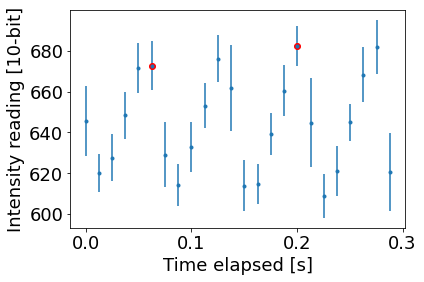

Period: 0.13772954924874795 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


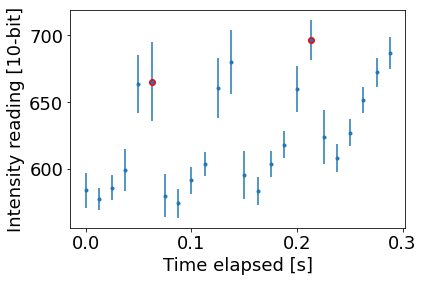

Period: 0.15025041736227046 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


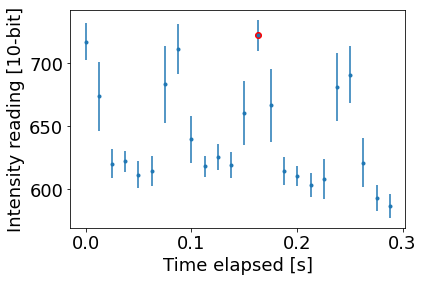

Period: nan +- nan s

0.012520868113522538 nan
24 24


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


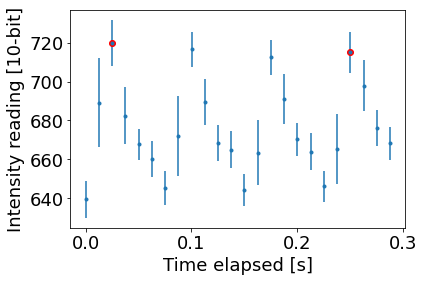

Period: 0.22537562604340566 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


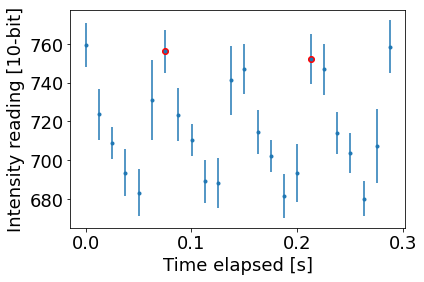

Period: 0.13772954924874795 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


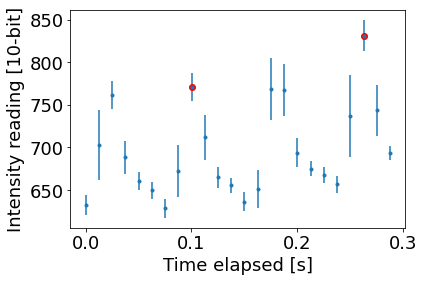

Period: 0.16277128547579298 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


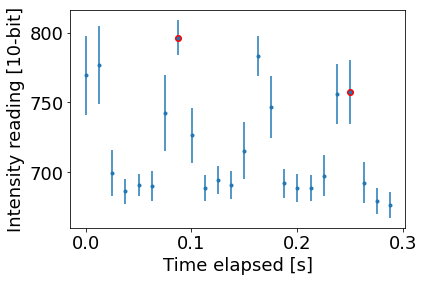

Period: 0.162771285475793 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


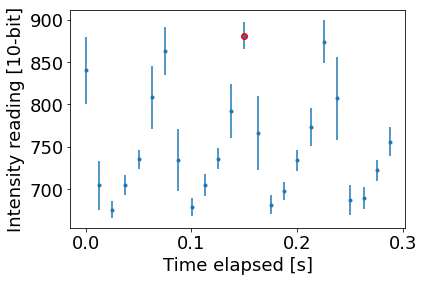

Period: nan +- nan s

0.012520868113522538 nan
24 24


/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yuliya/.local/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


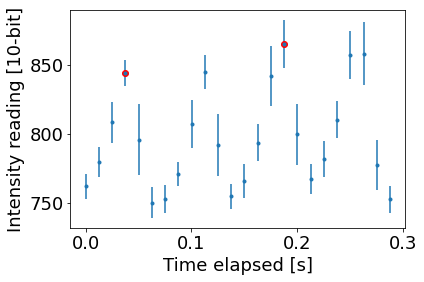

Period: 0.15025041736227043 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


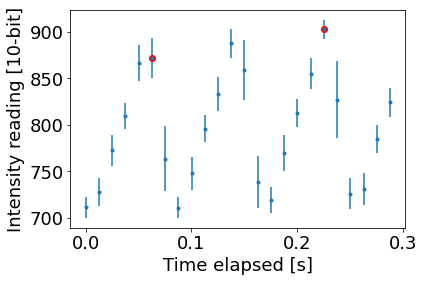

Period: 0.162771285475793 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


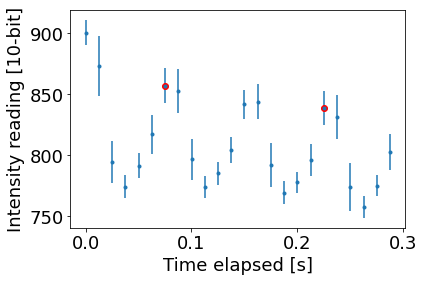

Period: 0.15025041736227046 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


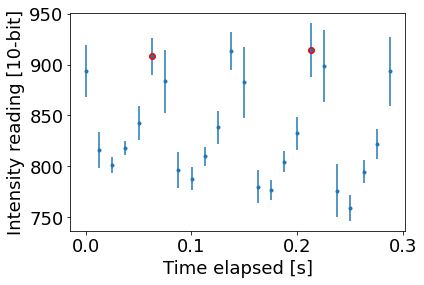

Period: 0.15025041736227046 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


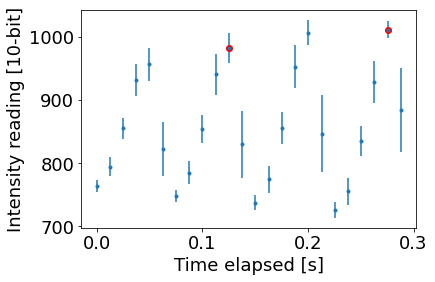

Period: 0.15025041736227043 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


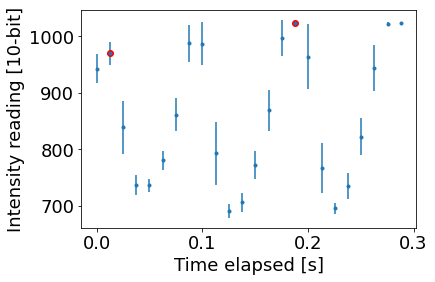

Period: 0.17529215358931552 +- 0.012520868113522538 s

0.012520868113522538 0.0
24 24


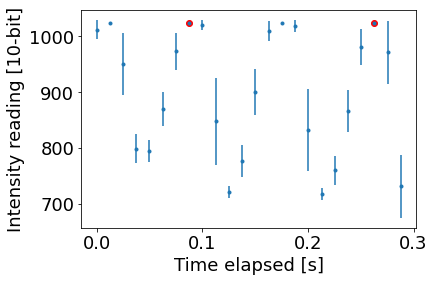

Period: 0.17529215358931555 +- 0.012520868113522538 s

0.012520868113522538 0.0
for factor 25: nan +- nan s


Text(0, 0.5, 'Period [s]')

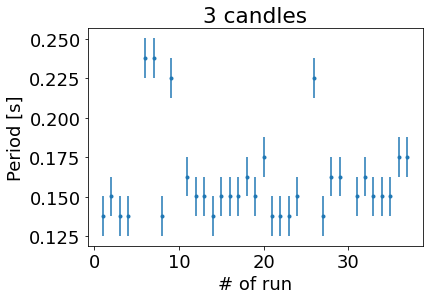

In [93]:
datapaths = ["./data/3candles_10bit_363_{}.csv".format(int(x)) for x in np.linspace(1, 45, 45)]

# remove runs that either vary too much in intensity or have double peaks
datapaths.remove("./data/3candles_10bit_363_7.csv")
datapaths.remove("./data/3candles_10bit_363_8.csv")
datapaths.remove("./data/3candles_10bit_363_10.csv")
datapaths.remove("./data/3candles_10bit_363_14.csv")
datapaths.remove("./data/3candles_10bit_363_15.csv")
datapaths.remove("./data/3candles_10bit_363_17.csv")
datapaths.remove("./data/3candles_10bit_363_25.csv")
datapaths.remove("./data/3candles_10bit_363_35.csv")

factors = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
p_3candles = np.zeros((len(factors), 2))

for i, f in enumerate(factors):
    p = []
    dp = []
    for d in datapaths:
        #print(d)
        if f > 16: 
            verbose = True
        else: verbose = False
        data = np.genfromtxt(d, delimiter=",")
        period, error = find_oscillations(data, rebin_factor=f, verbose=verbose)
        p.append(period)
        dp.append(error)
    p = np.asarray(p)
    dp = np.asarray(dp)
    print("for factor " + str(f) + ":", np.mean(p), "+-", np.mean(dp), "s" )
    p_3candles[i, :] = np.array([np.nanmean(p), np.nanmean(dp)])

n_runs = len(datapaths)
plt.title("3 candles")
plt.errorbar(np.linspace(1,n_runs,n_runs), p, dp, fmt=".")
plt.xlabel("# of run")
plt.ylabel("Period [s]")

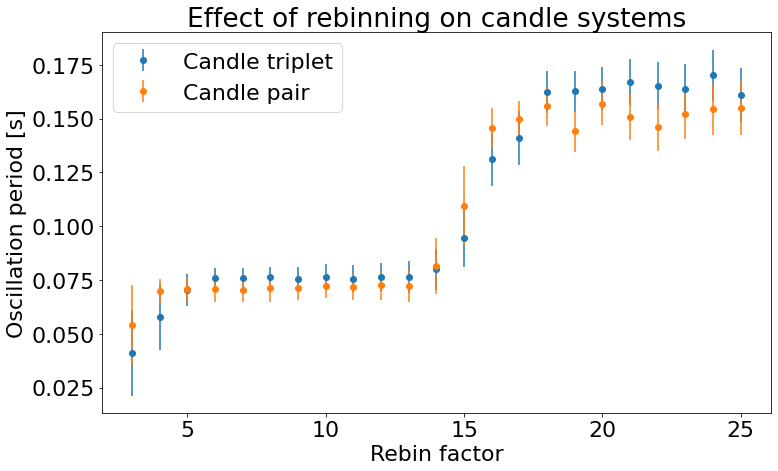

In [99]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize = (12,7))
plt.title("Effect of rebinning on candle systems")
plt.errorbar(factors, p_3candles[:, 0], yerr=p_3candles[:, 1], fmt="o", label="Candle triplet")
plt.errorbar(factors, p_2candles[:, 0], yerr=p_2candles[:, 1], fmt="o", label="Candle pair")
plt.legend()
plt.ylabel("Oscillation period [s]")
plt.xlabel("Rebin factor")
plt.show()

In [152]:
# period in the "good" region

p_3 = (np.mean(p_3candles[3:9, 0]), np.std(p_3candles[3:9, 0]))
p_3 = (p_3candles[6, 0], p_3candles[6, 1])
print(p_3)

(0.07553129089022244, 0.005574430831313003)


# To explore:
- How does the binning factor influence the error or extracted frequency?
- How does the 8bit vs 10bit influence the extracted frequency or its error?
- Do we see a different frequency for 2 candles and 3 candles?

## Notes:
- Data runs were excluded for the 3 candles because some of them showed oscillations with double peaks -- this messed with the peak finding algorithm (eg "./data/3candles_10bit_363_10.csv") or excluded because the amplitude of oscillation varied too much to capture good peaks

## Need more data:
- Film and detect the whole process of a candle burning down. See how the intensity of the detector changes with the height of the candle.
- Frequency of two sets of candles.